In [1]:
from math import log
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, mean_squared_error
from sklearn.model_selection import train_test_split
import time
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import chi2
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


In [2]:
def make_feature(df):
    for i in range(11):  # 11个商品项目 32个月的税务总和
        fea_name = ['fea_%d' % (j * 11 + i) for j in range(32)]
        df['item%d_sum' % i] = df[fea_name].sum(axis=1)
    # 32个月内全部商品，交税，纳税信息的和
    df['sum_ratal_32month'] = df[['fea_%d' % j for j in range(352)]].sum(axis=1)
    # print(list(df))
    df['sum_tax_ret'] = df.apply(lambda x:
                                 x['item0_sum'] + x['item1_sum'] + x['item2_sum'] +
                                 x['item3_sum'] + x['item4_sum'], axis=1)
    df['sum_tax_pay'] = df.apply(
        lambda x: x['item5_sum'] + x['item6_sum'] + x['item7_sum'] + x['item8_sum'] + x['item9_sum'] + x['item10_sum'],
        axis=1)
    # 交税/报税的比例
    df['ratal_rate'] = df.apply(
        lambda x: min(x['sum_tax_pay'] / (x['sum_tax_ret'] + 1), 1), axis=1
    )
    # 以4个月为一阶段计算这段时间交税，报税占的比例
    for i in range(32 // 4):
        buf_ret = df[['fea_%d' % (j * 11 + k) for j in range(
            i * 4, (i + 1) * 4) for k in range(0, 5)]].sum(axis=1)
        buf_pay = df[['fea_%d' % (j * 11 + k) for j in range(
            i * 4, (i + 1) * 4) for k in range(5, 11)]].sum(axis=1)
        df['stage_%d_ret_rate' % i] = buf_ret / df['sum_tax_ret']
        df['stage_%d_pay_rate' % i] = buf_pay / df['sum_tax_pay']
    # 每个月的交税总额
    for i in range(32):
        df['month%d_ret' % i] = df[['fea_%d' % (i * 11 + j) for j in range(0, 5)]].sum(axis=1)
        df['month%d_pay' % i] = df[['fea_%d' % (i * 11 + j) for j in range(5, 11)]].sum(axis=1)
    # 交/报税数据不为0的月数
    # df.apply(lambda x: print([df['month%d_ret' % i] > 0 for i in range(32)]), axis=1)
    ret_non0_month = []
    df_buf = df[['month%d_ret' % i for i in range(32)]]
    df['ret_non0_month'] = (df_buf > 0).astype(int).sum(axis=1)
    df_buf = df[['month%d_pay' % i for i in range(32)]]
    df['pay_non0_month'] = (df_buf > 0).astype(int).sum(axis=1)
    # 平均投资金额, 投资人数量
    # 已经在数据源头解决
    # 最大交税额和最小交税额
    df['min_tax_pay'] = df[['month%d_pay' % i for i in range(32)]].min(axis=1)
    df['max_tax_pay'] = df[['month%d_pay' % i for i in range(32)]].max(axis=1)
    return df


def from_pkl2_csv(data_dir):
    data_dir = "../data_final/all_data.pkl"
    fea_list = ['fea_%d' % i for i in range(352)]
    fea_list.extend(['sum_inv', 'sum_sales', 'sum_ratal', 'inv_mean', 'inv_n'])
    # eval_data = SVMDataSet(data_dir)
    # print(eval_data.svm_train_x.shape, len(fea_list))
    # df = pd.DataFrame(eval_data.svm_train_x, columns=fea_list)
    df = pd.read_csv('../data_final/all_data2.csv')
    # df2.insert(df2.shape[1], 'inv_mean', df['inv_mean'])
    # df2.insert(df2.shape[1], 'inv_n', df['inv_n'])
    # df2.to_csv('../data_final/all_data2.csv')
    df = make_feature(df)
    df.to_csv('../data_final/all_data.csv')


In [3]:
def optimal_binning_boundary(x: pd.Series, y: pd.Series, nan: float = -999.) -> list:
    '''
        利用决策树获得最优分箱的边界值列表
    '''
    boundary = []  # 待return的分箱边界值列表

    x = x.fillna(nan).values  # 填充缺失值
    y = y.values

    clf = DecisionTreeClassifier(criterion='entropy',  # “信息熵”最小化准则划分
                                 max_leaf_nodes=10,  # 最大叶子节点数
                                 min_samples_leaf=0.05)  # 叶子节点样本数量最小占比

    clf.fit(x.reshape(-1, 1), y)  # 训练决策树

    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    threshold = clf.tree_.threshold

    for i in range(n_nodes):
        if children_left[i] != children_right[i]:  # 获得决策树节点上的划分边界值
            boundary.append(threshold[i])

    boundary.sort()

    min_x = min(x)
    max_x = max(x) + 0.1  # +0.1是为了考虑后续groupby操作时，能包含特征最大值的样本
    boundary = [min_x] + boundary + [max_x]
    # print(boundary)
    return boundary


# 基于CART的最优分箱，也就是选择基尼指数下降最大的点
def get_var_median(data, var):
    """ 得到指定连续变量的所有元素的中位数列表
    Args:
        data: DataFrame，拟操作的数据集
        var: String，拟分箱的连续型变量名称
    Returns:
        关于连续变量的所有元素的中位列表，List
    """
    var_value_list = sorted(list(np.unique(data[var])))
    var_median_list = []
    # 可以假设这里data长度最少100,否则低于了划分条件
    if len(data[var]) < 100:
        return [var_value_list[int(len(var_value_list) * 0.5)]]
    idx = [0.5, 0.25, 0.75, 0.125, 0.375, 0.625, 0.875]
    for i in idx:
        var_median = var_value_list[int(len(var_value_list) * i)]
        var_median_list.append(var_median)
    return var_median_list



In [4]:
def calculate_gini(y):
    """ 计算基尼指数
    Args:
        y: Array，待计算数据的target，即0和1的数组
    Returns:
        基尼指数，float
    """
    # 将数组转化为列表
    y = y.tolist()
    probs = [y.count(i) / len(y) for i in np.unique(y)]
    gini = sum([p * (1 - p) for p in probs])
    return gini


def get_cart_split_point(data, var, target, min_sample):
    """ 获得最优的二值划分点（即基尼指数下降最大的点）
    Args:
        data: DataFrame，拟操作的数据集
        var: String，拟分箱的连续型变量名称
        target: String，Y列名称
        min_sample: int，分箱的最小数据样本，也就是数据量至少达到多少才需要去分箱，一般作用在开头或者结尾处的分箱点

    Returns:
        BestSplit_Point: 返回本次迭代的最优划分点，float
        BestSplit_Position: 返回最优划分点的位置，最左边为0，最右边为1，float
    """

    # 初始化
    Gini = calculate_gini(data[target].values)
    Best_Gini = 0.0
    BestSplit_Point = -99999
    BestSplit_Position = 0.0
    median_list = get_var_median(data, var)  # 获取当前数据集指定元素的所有中位数列表

    for i in range(len(median_list)):
        left = data[data[var] < median_list[i]]
        right = data[data[var] > median_list[i]]

        # 如果切分后的数据量少于指定阈值，跳出本次分箱计算
        if len(left) < min_sample or len(right) < min_sample:
            continue

        Left_Gini = calculate_gini(left[target].values)
        Right_Gini = calculate_gini(right[target].values)
        Left_Ratio = len(left) / len(data)
        Right_Ratio = len(right) / len(data)

        Temp_Gini = Gini - (Left_Gini * Left_Ratio + Right_Gini * Right_Ratio)
        if Temp_Gini > Best_Gini:
            Best_Gini = Temp_Gini
            BestSplit_Point = median_list[i]
            # 获取切分点的位置，最左边为0，最右边为1
            if len(median_list) > 1:
                BestSplit_Position = i / (len(median_list) - 1)
            else:
                BestSplit_Position = i / len(len(median_list))
        else:
            continue
    Gini = Gini - Best_Gini
    # print("最优切分点：", BestSplit_Point)
    return BestSplit_Point, BestSplit_Position


def get_cart_bincut(data, var, target, leaf_stop_percent=0.05):
    """ 计算最优分箱切分点
    Args:
        data: DataFrame，拟操作的数据集
        var: String，拟分箱的连续型变量名称
        target: String，Y列名称
        leaf_stop_percent: 叶子节点占比，作为停止条件，默认5%

    Returns:
        best_bincut: 最优的切分点列表，List
    """
    if var not in list(data):
        print("var not in data", var)
        return [0, 1]
    min_sample = len(data) * leaf_stop_percent
    best_bincut = []

    def cutting_data(data, var, target, min_sample, best_bincut):
        split_point, position = get_cart_split_point(data, var, target, min_sample)
        if split_point != -99999:
            best_bincut.append(split_point)

        # 根据最优切分点切分数据集，并对切分后的数据集递归计算切分点，直到满足停止条件
        # print("本次分箱的值域范围为{0} ~ {1}".format(data[var].min(), data[var].max()))
        left = data[data[var] < split_point]
        right = data[data[var] > split_point]

        # 当切分后的数据集仍大于最小数据样本要求，则继续切分
        if len(left) >= min_sample and position not in [0.0, 1.0]:
            cutting_data(left, var, target, min_sample, best_bincut)
        else:
            pass
        if len(right) >= min_sample and position not in [0.0, 1.0]:
            cutting_data(right, var, target, min_sample, best_bincut)
        else:
            pass
        return best_bincut

    best_bincut = cutting_data(data, var, target, min_sample, best_bincut)

    # 把切分点补上头尾
    best_bincut.append(data[var].min())
    best_bincut.append(data[var].max())
    best_bincut_set = set(best_bincut)
    best_bincut = list(best_bincut_set)

    best_bincut.remove(data[var].min())
    best_bincut.append(data[var].min() - 1)
    # 排序切分点
    best_bincut.sort()

    return best_bincut



In [5]:
# 基于卡方检验的最优化分
def calculate_chi(freq_array):
    """ 计算卡方值
    Args:
        freq_array: Array，待计算卡方值的二维数组，频数统计结果
    Returns:
        卡方值，float
    """
    # 检查是否为二维数组
    assert (freq_array.ndim == 2)

    # 计算每列的频数之和
    col_nums = freq_array.sum(axis=0)
    # 计算每行的频数之和
    row_nums = freq_array.sum(axis=1)
    # 计算总频数
    nums = freq_array.sum()
    # 计算期望频数
    E_nums = np.ones(freq_array.shape) * col_nums / nums
    E_nums = (E_nums.T * row_nums).T
    # 计算卡方值
    tmp_v = (freq_array - E_nums) ** 2 / E_nums
    # 如果期望频数为0，则计算结果记为0
    tmp_v[E_nums == 0] = 0
    chi_v = tmp_v.sum()
    return chi_v


def get_chimerge_bincut(data, var, target, max_group=None, chi_threshold=None):
    """ 计算卡方分箱的最优分箱点
    Args:
        data: DataFrame，待计算卡方分箱最优切分点列表的数据集
        var: 待计算的连续型变量名称
        target: 待计算的目标列Y的名称
        max_group: 最大的分箱数量（因为卡方分箱实际上是合并箱体的过程，需要限制下最大可以保留的分箱数量）
        chi_threshold: 卡方阈值，如果没有指定max_group，我们默认选择类别数量-1，置信度95%来设置阈值
        如果不知道卡方阈值怎么取，可以生成卡方表来看看，代码如下：
        import pandas as pd
        import numpy as np
        from scipy.stats import chi2
        p = [0.995, 0.99, 0.975, 0.95, 0.9, 0.5, 0.1, 0.05, 0.025, 0.01, 0.005]
        pd.DataFrame(np.array([chi2.isf(p, df=i) for i in range(1,10)]), columns=p, index=list(range(1,10)))
    Returns:
        最优切分点列表，List
    """
    df_buf = sorted(data[var])
    tmp_bin = np.unique([df_buf[i * 20] for i in range(len(df_buf) // 20)])
    tmp_bin = tmp_bin[np.isfinite(tmp_bin)]
    sel = pd.cut(data[var], tmp_bin, duplicates='drop', labels=tmp_bin[1:], right=False)
    freq_df = pd.crosstab(index=sel, columns=data[target])
    # 转化为二维数组
    freq_array = freq_df.values

    # 初始化箱体，每个元素单独一组
    best_bincut = freq_df.index.values

    # 初始化阈值 chi_threshold，如果没有指定 chi_threshold，则默认选择target数量-1，置信度95%来设置阈值
    if max_group is None:
        if chi_threshold is None:
            chi_threshold = chi2.isf(0.05, df=freq_array.shape[-1])

    # 开始迭代
    while True:
        min_chi = None
        min_idx = None
        for i in range(len(freq_array) - 1):
            # 两两计算相邻两组的卡方值，得到最小卡方值的两组
            v = calculate_chi(freq_array[i: i + 2])
            if min_chi is None or min_chi > v:
                min_chi = v
                min_idx = i

        # 是否继续迭代条件判断
        # 条件1：当前箱体数仍大于 最大分箱数量阈值
        # 条件2：当前最小卡方值仍小于制定卡方阈值
        if (max_group is not None and max_group < len(freq_array)) or (
                chi_threshold is not None and min_chi < chi_threshold):
            tmp = freq_array[min_idx] + freq_array[min_idx + 1]
            freq_array[min_idx] = tmp
            freq_array = np.delete(freq_array, min_idx + 1, 0)
            best_bincut = np.delete(best_bincut, min_idx + 1, 0)
        else:
            break

    # 把切分点补上头尾
    best_bincut = best_bincut.tolist()
    best_bincut.append(data[var].min())
    best_bincut.append(data[var].max())
    best_bincut_set = set(best_bincut)
    best_bincut = list(best_bincut_set)

    best_bincut.remove(data[var].min())
    best_bincut.append(data[var].min() - 1)
    # 排序切分点
    best_bincut.sort()

    return best_bincut


In [6]:
import random
def woe_iv(df, fea, fea_bins=None, fea_label=None, draw=None):
    '''
    计算分箱后的iv值，如不指定分箱方式，则采用最高iv法分箱
    :param df:
    :param fea:
    :param good_T:
    :param bad_T:
    :param fea_bins:
    :param fea_label:
    :return:
    '''
    if fea_bins is None:
        fea_bins = optimal_binning_boundary(df[fea], df['label'])
        fea_label = ['%.3e' % (fea_bins[i]) for i in range(1, len(fea_bins))]
        if len(fea_bins) < 5:
            return -1
    else:
        fea_bins[0]-=1e-3
    totalG_B = df.groupby(['label'])['label'].count()  # 计算正负样本多少个
    good_T, bad_T = totalG_B[0], totalG_B[1]
    sel = pd.cut(df[fea],
                 fea_bins,
                 labels=fea_label)
    if fea + '_cut' in list(df):
        df.pop(fea + '_cut')
    df.insert(df.shape[1], '%s_cut' % fea, sel)
    var1 = df.groupby(['%s_cut' % fea, 'label'])['label'].count()
    iv = 0
    woe_inv = [0] * len(fea_label)
    sample_rate = [0] * len(fea_label)
    bad_rate = [0] * len(fea_label)
    for i, invl in enumerate(fea_label):
        woe_inv[i] = math.log((var1[invl, 1] + 0.5 / bad_T) / (var1[invl, 0] + 0.5 / good_T), math.e)
        sample_rate[i] = (var1[invl,1] + var1[invl,0]) / 5000
        bad_rate[i] = var1[invl,1] / (var1[invl,1] + var1[invl,0])
        iv += woe_inv[i] * ((var1[invl,1] / bad_T) - (var1[invl,0] / good_T))
        woe_inv[i] += random.random()*1e-5 #加入随机干扰避免label重复
    if draw:
        fig = plt.figure(figsize=(8, 5))
        ax1 = fig.add_subplot(111)
        ax1.bar(fea_label, sample_rate)
        ax1.set_xticklabels(labels=fea_label, rotation=30)
        ax1.set_ylabel('箱内样本数量占比')
        ax2 = ax1.twinx()
        ax2.plot(fea_label, bad_rate, linewidth=2, color='red')
        ax2.scatter(fea_label, bad_rate, color='red')
        ax2.set_ylabel('箱内坏样本占比')
        plt.title('特征%s箱线图iv%.2f' % (fea, iv))
        plt.legend(['箱内样本数量占比', '箱内坏样本占比'])
        plt.savefig('箱线图%d份_%s_划分%s.jpg' % (len(fea_label), fea, draw))
        # plt.show()
    
    woe_encode_fea = pd.cut(df[fea], fea_bins, labels=woe_inv, ordered=True)
    
    return iv, woe_encode_fea


def format_print_list(out):
    for line in out:
        line = [str(e) for e in line]
        print(', '.join(line))


# 实现一个向前逐步选择
def cal_aic(model, x, y, y_hat):
    num_params = len(model.coef_) + 1
    mse = mean_squared_error(y, y_hat)
    aic = len(y) * log(mse) + 2 * num_params
    return aic


In [7]:
def bi_select_auc(data, fea, target, test_data=None):
    """
    向前逐步回归
    :param data: 数据
    :param target:目标值
    :return:
    """
    if test_data is None:
        data, test_data = train_test_split(data, test_size=0.3)  #, random_state=20220801
    variate = list(set(fea))
    # 参数
    selected = []  # 储存挑选的变量
    # 初始化
    # 初始化决定系数auc, 越大越好
    best_score, score_h = 0, 0
    # 循环删选变量,直至对所有变量进行了选择
    while variate:
        variate_r2 = []

        for var in variate:
            selected.append(var)
            # if len(selected) == 1:
            #     model = net.fit(train_data[selected[0]].values.reshape(-1, 1), y_train)
            #     y_pred = model.predict(test_data[selected[0]].values.reshape(-1, 1))
            # else:
            # y_pred = model.predict(test_data[selected])
            ks, auc, psi = cal_ks_psi_auc(data, selected, target, test_data)
            aic = auc
            variate_r2.append((aic, var))
            selected.remove(var)
            # 逐个添加变量，看看添加哪个变量可以使aic最小
        variate_r2.sort()
        print(variate_r2)
        score_f, var_f = variate_r2.pop()  # pop用于移除列表中的一个元素（默认最后一个元素），并且返回该元素的值
        if (best_score+1e-4) < score_f:  # 说明了加了该变量更好了就不移除了,否则就移除
            selected.append(var_f)
            best_score = score_f
            variate.remove(var_f)  # 在纯前向里，删掉避免了重复计算，关键看后向用不用到
            # 在后向里会判断移除它好不好，所以暂时不能remove
            print("R2_f={},continue!".format(best_score))
        else:
            break
    print(selected)
    return selected

def bi_select_ks(data, fea, target, test_data=None):
    """
    向前逐步回归
    :param data: 数据
    :param target:目标值
    :return:
    """
    if test_data is None:
        data, test_data = train_test_split(data, test_size=0.3)  #, random_state=20220801
    variate = list(set(fea))
    # 参数
    selected = []  # 储存挑选的变量
    # 初始化
    # 初始化决定系数auc, 越大越好
    best_score, score_h = 0, 0
    # 循环删选变量,直至对所有变量进行了选择
    while variate:
        variate_r2 = []

        for var in variate:
            selected.append(var)
            # if len(selected) == 1:
            #     model = net.fit(train_data[selected[0]].values.reshape(-1, 1), y_train)
            #     y_pred = model.predict(test_data[selected[0]].values.reshape(-1, 1))
            # else:
            # y_pred = model.predict(test_data[selected])
            ks, auc, psi = cal_ks_psi_auc(data, selected, target, test_data)
            aic = ks
            variate_r2.append((aic, var))
            selected.remove(var)
            # 逐个添加变量，看看添加哪个变量可以使aic最小
        variate_r2.sort()
        print(variate_r2)
        score_f, var_f = variate_r2.pop()  # pop用于移除列表中的一个元素（默认最后一个元素），并且返回该元素的值
        if (best_score+1e-4) < score_f:  # 说明了加了该变量更好了就不移除了,否则就移除
            selected.append(var_f)
            best_score = score_f
            variate.remove(var_f)  # 在纯前向里，删掉避免了重复计算，关键看后向用不用到
            # 在后向里会判断移除它好不好，所以暂时不能remove
            print("R2_f={},continue!".format(best_score))
        else:
            break
    print(selected)
    return selected

def back_selection_psi(data, fea, target, test_data=None):
    if test_data is None:
        data, test_data = train_test_split(data, test_size=0.3)
    variate = list(set(fea))
    # 参数
    selected = []  # 储存挑选的变量
    # 初始化决定系数psi, 越小越好
    best_score = 100
    # 循环删选变量,直至对所有变量进行了选择
    while variate:
        variate_r2 = []
        # 找到局部最优
        for var in variate:
            variate.remove(var)
            ks, auc, psi = cal_ks_psi_auc(data, variate, target, test_data)
            aic = psi
            variate_r2.append((aic, var))
            variate.append(var)
                
        variate_r2.sort(reverse=True)  # 降序排序r2，默认升序
        score, var = variate_r2.pop()  # pop用于移除列表中的一个元素（默认最后一个元素），并且返回该元素的值
        if best_score > score:  # 说明了移除了该变量更好了
            variate.remove(var)  # 判断过了，不管是好是坏，就删了
            selected.append(var)
            best_score = score
            print("R2={},continue!".format(best_score), var)
        else:
            print('for selection over!')
            break
    selected = [var for var in set(fea) if var not in selected]
    print(selected)
    return selected

def back_selection_ks(data, fea, target, test_data=None):
    if test_data is None:
        data, test_data = train_test_split(data, test_size=0.3)
    variate = list(set(fea))
    # 参数
    selected = []  # 储存挑选的变量
    # 初始化决定系数ks, 越大越好
    best_score = -1
    # 循环删选变量,直至对所有变量进行了选择
    while variate:
        variate_r2 = []
        # 找到局部最优
        for var in variate:
            variate.remove(var)
            ks, auc, psi = cal_ks_psi_auc(data, variate, target, test_data)
            aic = ks
            variate_r2.append((aic, var))
            variate.append(var)
                
        variate_r2.sort(reverse=False)  # 降序排序r2，默认升序
        score, var = variate_r2.pop()  # pop用于移除列表中的一个元素（默认最后一个元素），并且返回该元素的值
        if (best_score+1e-4) < score:  # 说明了移除了该变量更好了
            variate.remove(var)  # 判断过了，不管是好是坏，就删了
            selected.append(var)
            best_score = score
            print("R2={},continue!".format(best_score), var)
        else:
            print('for selection over!')
            break
    selected = [var for var in set(fea) if var not in selected]
    print(selected)
    return selected

def back_selection_auc(data, fea, target, test_data=None):
    if test_data is None:
        data, test_data = train_test_split(data, test_size=0.3)
    variate = list(set(fea))
    # 参数
    selected = []  # 储存挑选的变量
    # 初始化决定系数psi, 越小越好
    best_score = -1
    # 循环删选变量,直至对所有变量进行了选择
    while variate:
        variate_r2 = []
        # 找到局部最优
        for var in variate:
            variate.remove(var)
            ks, auc, psi = cal_ks_psi_auc(data, variate, target, test_data)
            aic = auc
            variate_r2.append((aic, var))
            variate.append(var)
                
        variate_r2.sort(reverse=False)  # 降序排序r2，默认升序
        score, var = variate_r2.pop()  # pop用于移除列表中的一个元素（默认最后一个元素），并且返回该元素的值
        if (best_score+1e-4) < score:  # 说明了移除了该变量更好了
            variate.remove(var)  # 判断过了，不管是好是坏，就删了
            selected.append(var)
            best_score = score
            print("R2={},continue!".format(best_score), var)
        else:
            print('for selection over!')
            break
    selected = [var for var in set(fea) if var not in selected]
    print(selected)
    return selected

# 目前获得了100个iv值较大的特征，现在需要用forward selection选择最好的20个，并送入线性预测模型预测
# 计算模型的psi，衡量预测的稳定性，选择psi小的
# ks取值越大越好，但最好不要超过75%
def cal_auc(data, fea, target, draw=False, test_data=None):
    net = LogisticRegression(penalty="l2", C=1.5, solver='liblinear', max_iter=30000)
    net.fit(data[fea], data[target])
    if test_data is not None:
        y_pred = net.predict_proba(test_data[fea])
        fpr, tpr, thresholds = roc_curve(test_data[target], y_pred[:, 1])
        ks = max(tpr-fpr)
    else:
        y_pred = net.predict_proba(data[fea])
        fpr, tpr, thresholds = roc_curve(data[target], y_pred[:, 1])
        ks = max(tpr-fpr)
    roc_auc_0 = auc(fpr, tpr)
    if draw:
        plt.plot(fpr, tpr)
    else:
        return roc_auc_0, ks, fpr, tpr
    return roc_auc_0, ks

# 还需要画出ks曲线，也就是按照分箱画出tpr-fpr-ks
def cal_ks_psi_auc(data, fea, target, test_data, draw=False):
    net = LogisticRegression(penalty="l2", C=1, solver='liblinear', max_iter=30000)
    net.fit(data[fea], data[target])
    test_pred = net.predict_proba(test_data[fea])[:, 1]
    test_fpr, test_tpr, thresholds = roc_curve(test_data[target], test_pred)
    test_ks = max(test_tpr-test_fpr)
    test_auc = auc(test_fpr, test_tpr)
    
    
    train_pred = net.predict_proba(data[fea])[:, 1]
    train_fpr, train_tpr, thresholds = roc_curve(data[target], train_pred)
    train_ks = max(train_tpr-train_fpr)
    train_auc = auc(train_fpr, train_tpr)
    # 计算psi
    actual_min = train_pred.min()  # 实际中的最小概率
    actual_max = train_pred.max()  # 实际中的最大概率
    binlen = (actual_max - actual_min) / 10 #分10箱
    cuts = [actual_min + i * binlen for i in range(1, 10)]#设定分组
    cuts[0] = -(float("inf"))
    cuts.append(float("inf"))
    actual_cuts = np.histogram(train_pred, bins=cuts)#将actual等宽分箱
    predict_cuts = np.histogram(test_pred, bins=cuts)#将predict按actual的分组等宽分箱
    
    actual_df = pd.DataFrame(actual_cuts[0],columns=['actual'])
    predict_df = pd.DataFrame(predict_cuts[0], columns=['predict'])
    # 计算数值为某个区间的训练集样本数和测试集样本数
    psi_df = pd.merge(actual_df,predict_df,right_index=True,left_index=True)
    psi_df['actual_rate'] = (psi_df['actual'] + 0.1) / psi_df['actual'].sum()#计算占比，分子加1，防止计算PSI时分子分母为0
    psi_df['predict_rate'] = (psi_df['predict'] + 0.1) / psi_df['predict'].sum()
    psi_df['psi'] = (psi_df['actual_rate'] - psi_df['predict_rate']) * np.log(
        psi_df['actual_rate'] / psi_df['predict_rate'])
    psi = psi_df['psi'].sum()
    
    if draw:
        # 画出 ks-auc图像
        p1 = plt.figure(figsize=(8,6) ,dpi=80)
        ax1 = p1.add_subplot(2,2,1)
        plt.title('roc曲线')
        plt.xlabel('fpr')  #设置x轴名称
        plt.ylabel('tpr')  #设置y轴名称
        plt.plot(train_fpr, train_tpr)
        plt.plot(test_fpr, test_tpr)
        plt.legend( ['train_roc' , 'test_roc'])  #添加注解

        ax2 = p1.add_subplot(2,2,2)
        plt.title('train ks曲线')
        plt.plot(range(len(train_tpr)), train_tpr)
        plt.plot(range(len(train_fpr)), train_fpr)
        plt.plot(range(len(train_fpr)), train_tpr-train_fpr)
        plt.legend( ['tpr' , 'fpr', 'ks'])  #添加注解

        ax3 = p1.add_subplot(2,2,3)
        plt.title('test ks曲线')
        plt.plot(range(len(test_tpr)), test_tpr)
        plt.plot(range(len(test_fpr)), test_fpr)
        plt.plot(range(len(test_tpr)), test_tpr-test_fpr)
        plt.legend( ['tpr' , 'fpr', 'ks'])  #添加注解
        ax4 = p1.add_subplot(2,2,4)
        plt.title('psi 对比')
        plt.plot(range(len(psi_df['actual_rate'])), psi_df['actual_rate'])
        plt.plot(range(len(psi_df['actual_rate'])), psi_df['predict_rate'])
        plt.legend( ['actual_rate' , 'predict_rate'])  #添加注解
        plt.savefig('./ks_auc_psi.jpg')
        plt.show()
        print(psi_df)
    return (train_ks+test_ks)/2, (train_auc+test_auc)/2, psi

In [10]:
def get_good_fea_list(df, fea_list=None, draw=False):
    
    # print(fea_list)
    useful_fea = []
    now = time.time()
    for fea in fea_list:
        if fea not in list(df):
            continue
        totalG_B = df.groupby(['label'])['label'].count()  # 计算正负样本多少个
        good_T, bad_T = totalG_B[0], totalG_B[1]
        bin_gini = get_cart_bincut(df, fea, 'label')
        label_gini = ['%.3e' % (bin_gini[i]) for i in range(1, len(bin_gini))]
        print("gini use time: ", time.time() - now)
        now = time.time()
        bin_iv = optimal_binning_boundary(df[fea], df['label'])
        label_iv = ['%.3e' % (bin_iv[i]) for i in range(1, len(bin_iv))]
        print("iv 用时：", time.time() - now)
        now = time.time()
        bin_kf = get_chimerge_bincut(df, fea, 'label', 10)
        label_kf = ['%.5e' % (bin_kf[i]) for i in range(1, len(bin_kf))]
        print("kf use time: ", time.time() - now)
        now = time.time()

        iv1, _ = woe_iv(df, fea, bin_gini, label_gini, draw='gini' if draw else None)
        iv2, _ = woe_iv(df, fea, bin_iv, label_iv, draw='iv' if draw else None)
        iv3, _ = woe_iv(df, fea, bin_kf, label_kf, draw='kf' if draw else None)
        # if iv1>0.3 or iv2>0.3 or iv3>0.3:
        print("fea: %s\tiv_gini: %.3f\t iv_iv: %.3f\t iv_kf: %.3f\n" % (fea, iv1, iv2, iv3))
        if iv1 > 0.5 or iv1 < 0:
            iv1 = 0
        if iv2 > 0.5 or iv2 < 0:
            iv2 = 0
        if iv3 > 0.5 or iv3 < 0:
            iv3 = 0
        if iv1>=iv2 and iv1>=iv3 and iv1>0:
            useful_fea.append([fea, iv1, bin_gini])
        elif iv2>=iv1 and iv2>=iv3 and iv2>0:
            useful_fea.append([fea, iv2, bin_iv])
        elif iv3>=iv2 and iv3>=iv1 and iv3>0:
            useful_fea.append([fea, iv3, bin_kf])

        # if iv > 0.02 and iv<0.6:
        #     good_fea.append([fea, iv])
    print("iv0.02-0.5 fea:", useful_fea)
    # format_print_list(useful_fea)
    # print("0.02-0.6 fea:", good_fea)
    return useful_fea


def draw_and_conclu(df):
    fea_list = fea_list_gini = fea_list_kf = '''fea_275
    lgb_pred'''.split('\n')
    # fea_list = list(df) 'lgb_pred', 'rf_pred',
    form_raw_fea = ['fea_88', 'fea_16', 'fea_176', 'fea_23', 'fea_72', 'fea_331', 'fea_175', 'fea_151', 'fea_3',
                    'fea_167', 'fea_174',
                    'fea_192', 'fea_80', 'fea_18', 'fea_59', 'fea_62', 'fea_75', 'fea_48', 'fea_208', 'fea_230']
    first_select = ['stage_2_ret_rate', 'stage_0_pay_rate', 'stage_3_pay_rate',
                    'fea_88', 'fea_16', 'fea_176', 'stage_1_ret_rate']
    second_select = ['fea_99', 'month1_pay', 'fea_77', 'fea_0', 'fea_55', 'month6_ret', 'fea_11',
                     'fea_38', 'fea_165', 'month2_ret', 'fea_132', 'ret_non0_month']
    fea_yty = ['fea_0', 'fea_66', 'fea_69', 'fea_142', 'fea_11']
    # for i in first_select:
    #     fea_list.remove(i)
    df.fillna(0.0, inplace=True)
    # model_train(df, fea_list, 'label')
    # bi_select(df, fea_list, 'label')
    final_fea = first_select
    dir_sele = ['fea_88', 'fea_16', 'fea_176', 'fea_23', 'ret_non0_month', 'fea_86', 'fea_174', 'fea_7', 'fea_187',
                'fea_59',
                'fea_225', 'month20_pay', 'fea_163', 'stage_2_ret_rate', 'stage_0_ret_rate', 'stage_5_ret_rate']
    final_fea.extend(second_select)
    # 画出箱线图
    # get_good_fea_list(df, final_fea, draw=True)
    # plt.cla()
    # plt.clf()
    # print("几个特征的箱线图画完了\n\n")
    # 用特征预测
    roc0,_ = cal_auc(df, first_select, 'label', True)
    roc1,_ = cal_auc(df, ['lgb_pred', 'rf_pred'], 'label', True)
    ori_fea = ['fea_%d' % i for i in range(352)]
    ori_fea.extend(['sum_inv', 'sum_sales', 'sum_ratal', 'inv_mean', 'inv_n'])
    roc2,_ = cal_auc(df, form_raw_fea, 'label', True)
    roc3,_ = cal_auc(df, second_select, 'label', True)
    roc4,_ = cal_auc(df, dir_sele, 'label', True)
    roc5,_ = cal_auc(df, fea_yty, 'label', True)
    plt.legend(['first_fea%.3f' % roc0, 'lgb+rf_pred%.3f' % roc1, 'from_raw_fea%.3f' % roc2,
                'sec_fea%.3f' % roc3, 'dir_sele%.3f' % roc4, 'yty%.3f' % roc5])
    plt.title('ROC')
    plt.savefig('roc_using_diff_fea.jpg')
    # plt.show()



In [9]:
df = pd.read_csv('../data_final/all_data.csv')
df.pop('id')
df.fillna(0.0, inplace=True)
data_train, data_test = train_test_split(df, test_size=0.3)
df = data_train

In [11]:
# 第一步，选出iv值在0.02-0.5之间的特征，并记录分类标准bins和label
full_fea = list(df) 
unconsider_fea = ['label']  #'lgb_pred', 'rf_pred', 
for i in unconsider_fea:
    full_fea.remove(i)
iv_ok_fea = get_good_fea_list(df, full_fea, False)
iv_ok_fea_name = [i[0] for i in iv_ok_fea]
iv_ok_fea_dir = {i[0]: [i[1], i[2]] for i in iv_ok_fea}

gini use time:  0.36898255348205566
iv 用时： 0.006511211395263672


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4023613929748535
fea: fea_0	iv_gini: 0.776	 iv_iv: 0.871	 iv_kf: 0.787

gini use time:  0.11467099189758301
iv 用时： 0.0029914379119873047


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4201350212097168
fea: fea_1	iv_gini: 0.152	 iv_iv: 0.363	 iv_kf: 0.309

gini use time:  0.09873485565185547
iv 用时： 0.001994609832763672
kf use time:  0.00797891616821289
fea: fea_2	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.030

gini use time:  0.10571885108947754
iv 用时： 0.0009965896606445312
kf use time:  0.008975982666015625
fea: fea_3	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.062

gini use time:  0.09374880790710449
iv 用时： 0.000997781753540039
kf use time:  0.008975744247436523
fea: fea_4	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.2812612056732178
iv 用时： 0.0030057430267333984
kf use time:  0.1829991340637207


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


fea: fea_5	iv_gini: 0.287	 iv_iv: 0.360	 iv_kf: 0.321

gini use time:  0.2592766284942627
iv 用时： 0.000997304916381836
kf use time:  0.042885541915893555
fea: fea_6	iv_gini: 0.099	 iv_iv: 0.114	 iv_kf: 0.138

gini use time:  0.09175491333007812
iv 用时： 0.0009975433349609375
kf use time:  0.008008956909179688
fea: fea_7	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


gini use time:  0.09671139717102051
iv 用时： 0.001994609832763672
kf use time:  0.009973526000976562
fea: fea_8	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.093

gini use time:  0.08879494667053223
iv 用时： 0.001961946487426758
kf use time:  0.008976221084594727
fea: fea_9	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


gini use time:  0.08976078033447266
iv 用时： 0.0019941329956054688
kf use time:  0.009974002838134766
fea: fea_10	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.002

gini use time:  0.3836045265197754
iv 用时： 0.004018306732177734


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4607701301574707
fea: fea_11	iv_gini: 0.716	 iv_iv: 0.785	 iv_kf: 0.745

gini use time:  0.11266684532165527
iv 用时： 0.004021167755126953


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4259202480316162
fea: fea_12	iv_gini: 0.133	 iv_iv: 0.301	 iv_kf: 0.282

gini use time:  0.09374713897705078
iv 用时： 0.0019659996032714844
kf use time:  0.009011268615722656
fea: fea_13	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.031

gini use time:  0.08975768089294434
iv 用时： 0.002958536148071289
kf use time:  0.010005474090576172
fea: fea_14	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.063

gini use time:  0.08972811698913574
iv 用时： 0.001994609832763672
kf use time:  0.006981372833251953
fea: fea_15	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.4328422546386719
iv 用时： 0.003989458084106445


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.32097816467285156
fea: fea_16	iv_gini: 0.392	 iv_iv: 0.437	 iv_kf: 0.459

gini use time:  0.2901937961578369
iv 用时： 0.001993417739868164
kf use time:  0.04092550277709961
fea: fea_17	iv_gini: 0.089	 iv_iv: 0.104	 iv_kf: 0.156

gini use time:  0.09471249580383301
iv 用时： 0.0019943714141845703
kf use time:  0.007979154586791992
fea: fea_18	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


gini use time:  0.09677290916442871
iv 用时： 0.0019631385803222656
kf use time:  0.010006904602050781
fea: fea_19	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.095

gini use time:  0.09271812438964844
iv 用时： 0.000997781753540039
kf use time:  0.008975982666015625
fea: fea_20	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.009

gini use time:  0.09278368949890137
iv 用时： 0.0019631385803222656
kf use time:  0.010134696960449219
fea: fea_21	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.032

gini use time:  0.5165872573852539
iv 用时： 0.005014181137084961


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4378349781036377
fea: fea_22	iv_gini: 0.616	 iv_iv: 0.679	 iv_kf: 0.606

gini use time:  0.11669635772705078
iv 用时： 0.0019936561584472656
kf use time:  0.00900888442993164
fea: fea_23	iv_gini: 0.000	 iv_iv: 0.052	 iv_kf: 0.072

gini use time:  0.09870457649230957
iv 用时： 0.001993417739868164
kf use time:  0.008011817932128906
fea: fea_24	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.001

gini use time:  0.09636402130126953
iv 用时： 0.000997781753540039
kf use time:  0.009011268615722656
fea: fea_25	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.065

gini use time:  0.0947115421295166
iv 用时： 0.0019941329956054688
kf use time:  0.007979154586791992
fea: fea_26	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.27587413787841797
iv 用时： 0.003990650177001953


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3031885623931885
fea: fea_27	iv_gini: 0.296	 iv_iv: 0.374	 iv_kf: 0.365

gini use time:  0.10631322860717773
iv 用时： 0.0009980201721191406
kf use time:  0.007978439331054688
fea: fea_28	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.093

gini use time:  0.09676837921142578
iv 用时： 0.0019676685333251953
kf use time:  0.007978677749633789
fea: fea_29	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09773850440979004
iv 用时： 0.0009975433349609375
kf use time:  0.008976459503173828
fea: fea_30	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.036

gini use time:  0.09773826599121094
iv 用时： 0.0009980201721191406
kf use time:  0.008975744247436523
fea: fea_31	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.008

gini use time:  0.09973311424255371
iv 用时： 0.0009975433349609375
kf use time:  0.008976221084594727
fea: fea_32	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.002

gini use time:  0.5302295684814453
iv 用时： 0.004021167755126953


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4983482360839844
fea: fea_33	iv_gini: 0.654	 iv_iv: 0.741	 iv_kf: 0.677

gini use time:  0.391920804977417
iv 用时： 0.004986763000488281


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.37775588035583496
fea: fea_34	iv_gini: 0.202	 iv_iv: 0.245	 iv_kf: 0.275

gini use time:  0.10471963882446289
iv 用时： 0.001994609832763672
kf use time:  0.0079803466796875
fea: fea_35	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.002

gini use time:  0.10273909568786621
iv 用时： 0.000982522964477539
kf use time:  0.010970115661621094
fea: fea_36	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.065

gini use time:  0.09873604774475098
iv 用时： 0.0009982585906982422
kf use time:  0.007978200912475586
fea: fea_37	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


gini use time:  0.6220479011535645
iv 用时： 0.00501704216003418


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.310166597366333
fea: fea_38	iv_gini: 0.340	 iv_iv: 0.421	 iv_kf: 0.358

gini use time:  0.36001086235046387
iv 用时： 0.0019943714141845703
kf use time:  0.052021026611328125
fea: fea_39	iv_gini: 0.081	 iv_iv: 0.104	 iv_kf: 0.100

gini use time:  0.10918736457824707
iv 用时： 0.0019941329956054688
kf use time:  0.008976936340332031


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


fea: fea_40	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.11635327339172363
iv 用时： 0.001993894577026367
kf use time:  0.009973764419555664
fea: fea_41	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.066

gini use time:  0.10440254211425781
iv 用时： 0.0009968280792236328
kf use time:  0.009008407592773438
fea: fea_42	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.007

gini use time:  0.1077120304107666
iv 用时： 0.0019621849060058594
kf use time:  0.007979154586791992
fea: fea_43	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.030

gini use time:  0.6854305267333984
iv 用时： 0.00402069091796875


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4957139492034912
fea: fea_44	iv_gini: 0.661	 iv_iv: 0.710	 iv_kf: 0.700

gini use time:  0.6214199066162109
iv 用时： 0.0040187835693359375


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.36969947814941406
fea: fea_45	iv_gini: 0.298	 iv_iv: 0.348	 iv_kf: 0.308

gini use time:  0.10871171951293945
iv 用时： 0.001992464065551758
kf use time:  0.008976221084594727
fea: fea_46	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.032

gini use time:  0.1186823844909668
iv 用时： 0.0019953250885009766
kf use time:  0.009973526000976562
fea: fea_47	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.034

gini use time:  0.10939240455627441
iv 用时： 0.0009965896606445312
kf use time:  0.00797891616821289
fea: fea_48	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.5257377624511719
iv 用时： 0.002991199493408203


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.32117438316345215
fea: fea_49	iv_gini: 0.424	 iv_iv: 0.514	 iv_kf: 0.461



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.25408434867858887
iv 用时： 0.002991914749145508
kf use time:  0.057848215103149414
fea: fea_50	iv_gini: 0.085	 iv_iv: 0.122	 iv_kf: 0.117

gini use time:  0.12266993522644043
iv 用时： 0.0010328292846679688
kf use time:  0.007978677749633789


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


fea: fea_51	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.10870933532714844
iv 用时： 0.000997781753540039
kf use time:  0.009972810745239258
fea: fea_52	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.036



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.10471987724304199
iv 用时： 0.0019948482513427734
kf use time:  0.008976459503173828
fea: fea_53	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.009

gini use time:  0.1077125072479248
iv 用时： 0.0009968280792236328
kf use time:  0.009009599685668945
fea: fea_54	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.031



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.7633726596832275
iv 用时： 0.004954338073730469


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5086731910705566
fea: fea_55	iv_gini: 0.713	 iv_iv: 0.788	 iv_kf: 0.741



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.4495687484741211
iv 用时： 0.002991914749145508


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.36007046699523926
fea: fea_56	iv_gini: 0.278	 iv_iv: 0.363	 iv_kf: 0.353

gini use time:  0.10967445373535156
iv 用时： 0.0019943714141845703
kf use time:  0.009008407592773438
fea: fea_57	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.032



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.10867810249328613
iv 用时： 0.001993894577026367
kf use time:  0.008975982666015625
fea: fea_58	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.065

gini use time:  0.10571813583374023
iv 用时： 0.0009970664978027344
kf use time:  0.008976221084594727
fea: fea_59	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.6517543792724609
iv 用时： 0.0029909610748291016


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.31914758682250977
fea: fea_60	iv_gini: 0.393	 iv_iv: 0.445	 iv_kf: 0.418

gini use time:  0.1326460838317871
iv 用时： 0.001993894577026367


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.09477829933166504
fea: fea_61	iv_gini: 0.105	 iv_iv: 0.152	 iv_kf: 0.159

gini use time:  0.10967540740966797
iv 用时： 0.0010340213775634766
kf use time:  0.008975744247436523
fea: fea_62	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.11365962028503418
iv 用时： 0.000997304916381836
kf use time:  0.010003089904785156
fea: fea_63	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.063

gini use time:  0.10965800285339355
iv 用时： 0.0010280609130859375
kf use time:  0.008975028991699219
fea: fea_64	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.003



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.11170482635498047
iv 用时： 0.000990152359008789
kf use time:  0.007982254028320312
fea: fea_65	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.031



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.7693154811859131
iv 用时： 0.004019021987915039


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4956793785095215
fea: fea_66	iv_gini: 0.712	 iv_iv: 0.809	 iv_kf: 0.728

gini use time:  0.12306571006774902
iv 用时： 0.001993417739868164
kf use time:  0.008975982666015625
fea: fea_67	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.054



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.11968207359313965
iv 用时： 0.0009963512420654297
kf use time:  0.009008407592773438
fea: fea_68	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.001

gini use time:  0.11269831657409668
iv 用时： 0.001995086669921875
kf use time:  0.00894474983215332
fea: fea_69	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.065



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.11572146415710449
iv 用时： 0.0009944438934326172
kf use time:  0.007978677749633789
fea: fea_70	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.7738866806030273
iv 用时： 0.0029823780059814453


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3201115131378174
fea: fea_71	iv_gini: 0.358	 iv_iv: 0.387	 iv_kf: 0.376

gini use time:  0.1326754093170166
iv 用时： 0.0009663105010986328
kf use time:  0.03494119644165039


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


fea: fea_72	iv_gini: 0.067	 iv_iv: 0.077	 iv_kf: 0.172

gini use time:  0.12270712852478027
iv 用时： 0.000995635986328125
kf use time:  0.00797891616821289
fea: fea_73	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.11669015884399414
iv 用时： 0.0009949207305908203
kf use time:  0.009973526000976562
fea: fea_74	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.070

gini use time:  0.11822938919067383
iv 用时： 0.001994609832763672
kf use time:  0.007979631423950195
fea: fea_75	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.036



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.11668753623962402
iv 用时： 0.0019943714141845703
kf use time:  0.008011102676391602
fea: fea_76	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.032

gini use time:  0.6053504943847656
iv 用时： 0.003989696502685547


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.48647475242614746
fea: fea_77	iv_gini: 0.645	 iv_iv: 0.707	 iv_kf: 0.642

gini use time:  0.1206512451171875
iv 用时： 0.0009965896606445312
kf use time:  0.009008407592773438
fea: fea_78	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.078



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.11864948272705078
iv 用时： 0.001995086669921875
kf use time:  0.007978439331054688
fea: fea_79	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.001

gini use time:  0.11469411849975586
iv 用时： 0.0019943714141845703
kf use time:  0.007978439331054688
fea: fea_80	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.034



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.12167477607727051
iv 用时： 0.000997304916381836
kf use time:  0.007979154586791992
fea: fea_81	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.7305567264556885
iv 用时： 0.00401759147644043


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3310840129852295
fea: fea_82	iv_gini: 0.353	 iv_iv: 0.409	 iv_kf: 0.355



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.3891422748565674
iv 用时： 0.000995635986328125
kf use time:  0.032911062240600586
fea: fea_83	iv_gini: 0.033	 iv_iv: 0.046	 iv_kf: 0.136

gini use time:  0.11768722534179688
iv 用时： 0.001995086669921875
kf use time:  0.007008790969848633
fea: fea_84	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.1206815242767334
iv 用时： 0.0019621849060058594
kf use time:  0.009007453918457031
fea: fea_85	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.035

gini use time:  0.1216428279876709
iv 用时： 0.0008678436279296875
kf use time:  0.00897836685180664
fea: fea_86	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.030



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.12267398834228516
iv 用时： 0.0009953975677490234
kf use time:  0.007978677749633789
fea: fea_87	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.002



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.8858718872070312
iv 用时： 0.0039882659912109375


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5106940269470215
fea: fea_88	iv_gini: 0.714	 iv_iv: 0.820	 iv_kf: 0.788

gini use time:  0.14557909965515137
iv 用时： 0.003988981246948242


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3660573959350586
fea: fea_89	iv_gini: 0.213	 iv_iv: 0.366	 iv_kf: 0.296

gini use time:  0.12164020538330078
iv 用时： 0.0019941329956054688
kf use time:  0.00797891616821289
fea: fea_90	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.001



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.12366914749145508
iv 用时： 0.001994609832763672
kf use time:  0.009007692337036133
fea: fea_91	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.033

gini use time:  0.11935281753540039
iv 用时： 0.0009968280792236328
kf use time:  0.007978439331054688
fea: fea_92	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.48769640922546387
iv 用时： 0.003989219665527344


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.33011841773986816
fea: fea_93	iv_gini: 0.371	 iv_iv: 0.426	 iv_kf: 0.422



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.2773728370666504
iv 用时： 0.0019958019256591797
kf use time:  0.03992509841918945
fea: fea_94	iv_gini: 0.114	 iv_iv: 0.117	 iv_kf: 0.189

gini use time:  0.12096738815307617
iv 用时： 0.001959562301635742
kf use time:  0.007978677749633789


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


fea: fea_95	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.125701904296875
iv 用时： 0.0019893646240234375
kf use time:  0.009978532791137695
fea: fea_96	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.070



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.1336371898651123
iv 用时： 0.0009937286376953125
kf use time:  0.007950067520141602
fea: fea_97	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.023

gini use time:  0.12470030784606934
iv 用时： 0.0019702911376953125
kf use time:  0.007970094680786133
fea: fea_98	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.030



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.1543612480163574
iv 用时： 0.003988981246948242


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.49669861793518066
fea: fea_99	iv_gini: 0.687	 iv_iv: 0.749	 iv_kf: 0.710

gini use time:  0.15056538581848145
iv 用时： 0.0030193328857421875


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3809816837310791
fea: fea_100	iv_gini: 0.222	 iv_iv: 0.364	 iv_kf: 0.297

gini use time:  0.126633882522583
iv 用时： 0.003011941909790039
kf use time:  0.007564544677734375
fea: fea_101	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.001



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.1266639232635498
iv 用时： 0.0009796619415283203
kf use time:  0.007946968078613281
fea: fea_102	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.003

gini use time:  0.1237039566040039
iv 用时： 0.0009942054748535156
kf use time:  0.006987094879150391
fea: fea_103	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.7727866172790527
iv 用时： 0.003022432327270508


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.32413387298583984
fea: fea_104	iv_gini: 0.349	 iv_iv: 0.389	 iv_kf: 0.391



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.2872035503387451
iv 用时： 0.002025604248046875
kf use time:  0.038863420486450195
fea: fea_105	iv_gini: 0.094	 iv_iv: 0.108	 iv_kf: 0.133

gini use time:  0.12770295143127441
iv 用时： 0.0019817352294921875
kf use time:  0.0069828033447265625
fea: fea_106	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.13065123558044434
iv 用时： 0.001961946487426758
kf use time:  0.008976221084594727
fea: fea_107	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.066

gini use time:  0.12683749198913574
iv 用时： 0.0010135173797607422
kf use time:  0.007978439331054688
fea: fea_108	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.036



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.13065099716186523
iv 用时： 0.0009558200836181641
kf use time:  0.00801539421081543
fea: fea_109	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.030



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.7843554019927979
iv 用时： 0.00601959228515625


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4807124137878418
fea: fea_110	iv_gini: 0.617	 iv_iv: 0.716	 iv_kf: 0.616

gini use time:  0.13460946083068848
iv 用时： 0.0020232200622558594
kf use time:  0.007947206497192383
fea: fea_111	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.052



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.13268208503723145
iv 用时： 0.0009639263153076172
kf use time:  0.008012533187866211
fea: fea_112	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.001

gini use time:  0.12765908241271973
iv 用时： 0.001991748809814453
kf use time:  0.008973121643066406
fea: fea_113	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.034



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.13160037994384766
iv 用时： 0.001020669937133789
kf use time:  0.007956504821777344
fea: fea_114	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.8328089714050293
iv 用时： 0.002989053726196289


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.31603527069091797
fea: fea_115	iv_gini: 0.352	 iv_iv: 0.405	 iv_kf: 0.392

gini use time:  0.13662433624267578
iv 用时： 0.001008749008178711
kf use time:  0.007977724075317383
fea: fea_116	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.044



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.1326150894165039
iv 用时： 0.0020265579223632812
kf use time:  0.00698089599609375
fea: fea_117	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.1296525001525879
iv 用时： 0.0009999275207519531
kf use time:  0.009972095489501953
fea: fea_118	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.065



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.13660717010498047
iv 用时： 0.0019888877868652344
kf use time:  0.007980585098266602
fea: fea_119	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.033

gini use time:  0.13068366050720215
iv 用时： 0.0019609928131103516
kf use time:  0.008011341094970703
fea: fea_120	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.030



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.8155405521392822
iv 用时： 0.004022836685180664


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.48766469955444336
fea: fea_121	iv_gini: 0.575	 iv_iv: 0.632	 iv_kf: 0.615

gini use time:  0.14059090614318848
iv 用时： 0.0009963512420654297
kf use time:  0.008976221084594727
fea: fea_122	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.051



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.13760113716125488
iv 用时： 0.0009958744049072266
kf use time:  0.008013248443603516
fea: fea_123	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.030

gini use time:  0.13364291191101074
iv 用时： 0.0009627342224121094
kf use time:  0.009974956512451172
fea: fea_124	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.063



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.1386277675628662
iv 用时： 0.0010287761688232422
kf use time:  0.007981538772583008
fea: fea_125	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.8745946884155273
iv 用时： 0.004018068313598633


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3111686706542969
fea: fea_126	iv_gini: 0.316	 iv_iv: 0.403	 iv_kf: 0.305

gini use time:  0.1397569179534912
iv 用时： 0.001993417739868164
kf use time:  0.009007692337036133
fea: fea_127	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.013



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.13660311698913574
iv 用时： 0.0019948482513427734
kf use time:  0.006981372833251953
fea: fea_128	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.13863039016723633
iv 用时： 0.0010311603546142578
kf use time:  0.009940147399902344
fea: fea_129	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.065



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.14062237739562988
iv 用时： 0.0009975433349609375
kf use time:  0.008976221084594727
fea: fea_130	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.006

gini use time:  0.13464045524597168
iv 用时： 0.0009968280792236328
kf use time:  0.00797891616821289
fea: fea_131	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.031



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.259953260421753
iv 用时： 0.004016876220703125


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.49898338317871094
fea: fea_132	iv_gini: 0.557	 iv_iv: 0.613	 iv_kf: 0.530



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.8139240741729736
iv 用时： 0.003989219665527344


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.399965763092041
fea: fea_133	iv_gini: 0.272	 iv_iv: 0.361	 iv_kf: 0.342

gini use time:  0.14358282089233398
iv 用时： 0.002027273178100586
kf use time:  0.008942842483520508
fea: fea_134	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.032



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.1406238079071045
iv 用时： 0.000997304916381836
kf use time:  0.008976459503173828
fea: fea_135	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.063

gini use time:  0.13683271408081055
iv 用时： 0.0019948482513427734
kf use time:  0.007978200912475586
fea: fea_136	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.7544488906860352
iv 用时： 0.003998994827270508


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.34747791290283203
fea: fea_137	iv_gini: 0.270	 iv_iv: 0.355	 iv_kf: 0.347



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.43783044815063477
iv 用时： 0.0020294189453125
kf use time:  0.03889203071594238
fea: fea_138	iv_gini: 0.055	 iv_iv: 0.076	 iv_kf: 0.202

gini use time:  0.1655271053314209


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.001993417739868164
kf use time:  0.009011983871459961
fea: fea_139	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.152557373046875
iv 用时： 0.0009965896606445312
kf use time:  0.010004281997680664
fea: fea_140	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.096



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.14887738227844238
iv 用时： 0.001020669937133789
kf use time:  0.008951187133789062
fea: fea_141	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.014

gini use time:  0.14265155792236328
iv 用时： 0.002000570297241211
kf use time:  0.007969856262207031
fea: fea_142	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.031



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.1838738918304443
iv 用时： 0.004019975662231445


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5126574039459229
fea: fea_143	iv_gini: 0.528	 iv_iv: 0.613	 iv_kf: 0.552



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.1213228702545166
iv 用时： 0.003988981246948242


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.40694475173950195
fea: fea_144	iv_gini: 0.287	 iv_iv: 0.360	 iv_kf: 0.375

gini use time:  0.15355825424194336
iv 用时： 0.0009968280792236328
kf use time:  0.009974241256713867
fea: fea_145	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.032



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.15658092498779297
iv 用时： 0.0019948482513427734
kf use time:  0.007978439331054688
fea: fea_146	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.031

gini use time:  0.1416480541229248
iv 用时： 0.0019681453704833984
kf use time:  0.007978677749633789
fea: fea_147	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.0766806602478027
iv 用时： 0.0029876232147216797


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.38796401023864746
fea: fea_148	iv_gini: 0.343	 iv_iv: 0.392	 iv_kf: 0.405



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.5998618602752686
iv 用时： 0.0020265579223632812
kf use time:  0.037899017333984375
fea: fea_149	iv_gini: 0.049	 iv_iv: 0.076	 iv_kf: 0.218



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.1685178279876709
iv 用时： 0.0009965896606445312
kf use time:  0.008976459503173828
fea: fea_150	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.14564275741577148
iv 用时： 0.001964092254638672
kf use time:  0.009972095489501953
fea: fea_151	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.067



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.1466078758239746
iv 用时： 0.000997304916381836
kf use time:  0.007979154586791992
fea: fea_152	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.022

gini use time:  0.1685495376586914
iv 用时： 0.0009980201721191406
kf use time:  0.008975505828857422


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


fea: fea_153	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.032

gini use time:  1.651817798614502
iv 用时： 0.005013942718505859


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5176215171813965
fea: fea_154	iv_gini: 0.562	 iv_iv: 0.620	 iv_kf: 0.522



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.8135895729064941
iv 用时： 0.004021406173706055


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.39546680450439453
fea: fea_155	iv_gini: 0.240	 iv_iv: 0.301	 iv_kf: 0.260

gini use time:  0.1506023406982422
iv 用时： 0.00196075439453125
kf use time:  0.008010387420654297
fea: fea_156	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.031



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.15058231353759766
iv 用时： 0.0009808540344238281
kf use time:  0.009007453918457031
fea: fea_157	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.001

gini use time:  0.16655635833740234


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0019614696502685547
kf use time:  0.009029388427734375
fea: fea_158	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.9340944290161133
iv 用时： 0.002992391586303711


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.35754823684692383
fea: fea_159	iv_gini: 0.395	 iv_iv: 0.433	 iv_kf: 0.389

gini use time:  0.19046735763549805


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0029904842376708984
kf use time:  0.050866127014160156
fea: fea_160	iv_gini: 0.056	 iv_iv: 0.070	 iv_kf: 0.139



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.1795189380645752
iv 用时： 0.001994609832763672
kf use time:  0.008976221084594727
fea: fea_161	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.15561556816101074
iv 用时： 0.001995563507080078
kf use time:  0.008975982666015625
fea: fea_162	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.064



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.1600489616394043
iv 用时： 0.0010242462158203125
kf use time:  0.007973194122314453
fea: fea_163	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.004

gini use time:  0.17949485778808594


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0019936561584472656
kf use time:  0.00997471809387207
fea: fea_164	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.031



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.5170879364013672
iv 用时： 0.003987550735473633


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5525596141815186
fea: fea_165	iv_gini: 0.411	 iv_iv: 0.583	 iv_kf: 0.518

gini use time:  0.16083073616027832
iv 用时： 0.0009992122650146484
kf use time:  0.007983684539794922
fea: fea_166	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.021



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.1555924415588379
iv 用时： 0.001986265182495117
kf use time:  0.007973909378051758
fea: fea_167	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.031

gini use time:  0.15259623527526855
iv 用时： 0.0009980201721191406
kf use time:  0.007946014404296875
fea: fea_168	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.004



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.1566162109375
iv 用时： 0.0019872188568115234
kf use time:  0.00798344612121582
fea: fea_169	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.3327665328979492
iv 用时： 0.003988981246948242


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.34615111351013184
fea: fea_170	iv_gini: 0.327	 iv_iv: 0.385	 iv_kf: 0.340

gini use time:  0.18251466751098633


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.001959562301635742
kf use time:  0.008976936340332031
fea: fea_171	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.15358996391296387
iv 用时： 0.0020253658294677734
kf use time:  0.006978273391723633
fea: fea_172	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.16221952438354492
iv 用时： 0.0009968280792236328
kf use time:  0.009008407592773438
fea: fea_173	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.011

gini use time:  0.15658164024353027
iv 用时： 0.0019626617431640625
kf use time:  0.008975982666015625


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


fea: fea_174	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.027

gini use time:  0.16474604606628418
iv 用时： 0.0019922256469726562
kf use time:  0.008976459503173828
fea: fea_175	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.062



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.7500298023223877
iv 用时： 0.003954648971557617


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.53670334815979
fea: fea_176	iv_gini: 0.440	 iv_iv: 0.515	 iv_kf: 0.441



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.7452375888824463
iv 用时： 0.0030214786529541016


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3034541606903076
fea: fea_177	iv_gini: 0.164	 iv_iv: 0.182	 iv_kf: 0.154

gini use time:  0.16054368019104004
iv 用时： 0.0009963512420654297
kf use time:  0.00797891616821289
fea: fea_178	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.031



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.16067743301391602
iv 用时： 0.0009961128234863281
kf use time:  0.007978677749633789
fea: fea_179	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.003

gini use time:  0.15558457374572754
iv 用时： 0.000997304916381836
kf use time:  0.008007526397705078
fea: fea_180	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.9824676513671875
iv 用时： 0.0029916763305664062


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.26859498023986816
fea: fea_181	iv_gini: 0.268	 iv_iv: 0.302	 iv_kf: 0.262

gini use time:  0.16456031799316406
iv 用时： 0.0019943714141845703
kf use time:  0.00797891616821289


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


fea: fea_182	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.16456222534179688
iv 用时： 0.000997781753540039
kf use time:  0.0069811344146728516
fea: fea_183	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.16057038307189941
iv 用时： 0.0009984970092773438
kf use time:  0.007977962493896484
fea: fea_184	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.004

gini use time:  0.16057133674621582
iv 用时： 0.0019941329956054688
kf use time:  0.007979154586791992
fea: fea_185	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.001



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.15957379341125488
iv 用时： 0.0009970664978027344
kf use time:  0.008975744247436523
fea: fea_186	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.062

gini use time:  1.0186717510223389
iv 用时： 0.003989219665527344


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4801013469696045
fea: fea_187	iv_gini: 0.339	 iv_iv: 0.382	 iv_kf: 0.422



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.026278018951416
iv 用时： 0.002991914749145508


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.30518484115600586
fea: fea_188	iv_gini: 0.167	 iv_iv: 0.191	 iv_kf: 0.164

gini use time:  0.16456127166748047
iv 用时： 0.0009961128234863281
kf use time:  0.009974241256713867
fea: fea_189	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.062



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.16206121444702148
iv 用时： 0.0019948482513427734
kf use time:  0.008976221084594727
fea: fea_190	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.064

gini use time:  0.15857672691345215
iv 用时： 0.0009965896606445312
kf use time:  0.00797891616821289
fea: fea_191	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.16156792640686035
iv 用时： 0.000997304916381836
kf use time:  0.007979154586791992
fea: fea_192	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.12067699432373047
iv 用时： 0.0019948482513427734
kf use time:  0.007980823516845703
fea: fea_193	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.07579565048217773
iv 用时： 0.0009899139404296875
kf use time:  0.008976936340332031
fea: fea_194	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.07779145240783691
iv 用时： 0.0009980201721191406
kf use time:  0.007977724075317383
fea: fea_195	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.1216745376586914
iv 用时： 0.0019948482513427734
kf use time:  0.009975194931030273
fea: fea_196	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.1242218017578125
iv 用时： 0.000985860824584961
kf use time:  0.007978439331054688
fea: fea_197	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.385941982269287
iv 用时： 0.004020214080810547


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.46176934242248535
fea: fea_198	iv_gini: 0.355	 iv_iv: 0.408	 iv_kf: 0.370



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.3393356800079346
iv 用时： 0.004020214080810547


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.29979515075683594
fea: fea_199	iv_gini: 0.139	 iv_iv: 0.189	 iv_kf: 0.130

gini use time:  0.17250561714172363
iv 用时： 0.0019943714141845703
kf use time:  0.00897669792175293


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

fea: fea_200	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.031

gini use time:  0.1675701141357422
iv 用时： 0.0009791851043701172
kf use time:  0.008978605270385742
fea: fea_201	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.063

gini use time:  0.17080283164978027
iv 用时： 0.001024007797241211
kf use time:  0.007951736450195312
fea: fea_202	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.16456317901611328
iv 用时： 0.0019915103912353516
kf use time:  0.007978677749633789


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


fea: fea_203	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09375143051147461
iv 用时： 0.001992940902709961
kf use time:  0.007978439331054688
fea: fea_204	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.08577299118041992
iv 用时： 0.0009951591491699219
kf use time:  0.007978200912475586


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


fea: fea_205	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.08577132225036621
iv 用时： 0.0009968280792236328
kf use time:  0.007978677749633789
fea: fea_206	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.08178234100341797
iv 用时： 0.0009975433349609375
kf use time:  0.00797724723815918
fea: fea_207	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.13164854049682617
iv 用时： 0.0019948482513427734
kf use time:  0.00797891616821289
fea: fea_208	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.5737593173980713
iv 用时： 0.003988742828369141


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.45880579948425293
fea: fea_209	iv_gini: 0.439	 iv_iv: 0.510	 iv_kf: 0.486

gini use time:  0.17350459098815918
iv 用时： 0.001995563507080078
kf use time:  0.00997304916381836


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

fea: fea_210	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.033

gini use time:  0.16926193237304688
iv 用时： 0.00102996826171875
kf use time:  0.006981372833251953
fea: fea_211	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.030

gini use time:  0.1765289306640625
iv 用时： 0.0019941329956054688
kf use time:  0.008975982666015625
fea: fea_212	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.032

gini use time:  0.1685490608215332
iv 用时： 0.0009980201721191406
kf use time:  0.008010625839233398


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

fea: fea_213	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.1685178279876709
iv 用时： 0.0019941329956054688
kf use time:  0.006981611251831055
fea: fea_214	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.08776497840881348
iv 用时： 0.0009980201721191406
kf use time:  0.007978439331054688
fea: fea_215	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.0797872543334961
iv 用时： 0.0009965896606445312
kf use time:  0.008012056350708008
fea: fea_216	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.07875657081604004
iv 用时： 0.0019941329956054688
kf use time:  0.006981611251831055


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

fea: fea_217	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.08218836784362793
iv 用时： 0.001995086669921875
kf use time:  0.007009744644165039
fea: fea_218	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.16552948951721191
iv 用时： 0.0019941329956054688
kf use time:  0.006981611251831055
fea: fea_219	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.6432807445526123
iv 用时： 0.004987955093383789


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4870426654815674
fea: fea_220	iv_gini: 0.407	 iv_iv: 0.555	 iv_kf: 0.467



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.6029419898986816
iv 用时： 0.0029909610748291016


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3369715213775635
fea: fea_221	iv_gini: 0.182	 iv_iv: 0.192	 iv_kf: 0.141

gini use time:  0.1765279769897461
iv 用时： 0.002026081085205078
kf use time:  0.007947206497192383


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


fea: fea_222	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.030

gini use time:  0.18251252174377441
iv 用时： 0.0009968280792236328
kf use time:  0.008976221084594727
fea: fea_223	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.033



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.17154192924499512
iv 用时： 0.0019960403442382812
kf use time:  0.007977008819580078
fea: fea_224	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.15857648849487305
iv 用时： 0.001993894577026367
kf use time:  0.007665157318115234
fea: fea_225	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.08284497261047363
iv 用时： 0.0019948482513427734
kf use time:  0.006981611251831055
fea: fea_226	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.0827786922454834
iv 用时： 0.000997781753540039
kf use time:  0.008996248245239258
fea: fea_227	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.08575057983398438


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0019941329956054688
kf use time:  0.00797891616821289
fea: fea_228	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.08477377891540527
iv 用时： 0.0009968280792236328
kf use time:  0.006983518600463867
fea: fea_229	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.13364195823669434
iv 用时： 0.0009975433349609375
kf use time:  0.009005308151245117
fea: fea_230	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.8161389827728271
iv 用时： 0.00396275520324707


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4697456359863281
fea: fea_231	iv_gini: 0.372	 iv_iv: 0.450	 iv_kf: 0.399



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.9757013320922852
iv 用时： 0.002991914749145508


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.34170055389404297
fea: fea_232	iv_gini: 0.178	 iv_iv: 0.222	 iv_kf: 0.204

gini use time:  0.18650269508361816
iv 用时： 0.000995635986328125


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


kf use time:  0.010970830917358398
fea: fea_233	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.030

gini use time:  0.18051719665527344


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.001994609832763672
kf use time:  0.010970830917358398
fea: fea_234	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.002

gini use time:  0.17852354049682617


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0019936561584472656
kf use time:  0.008980274200439453
fea: fea_235	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.19447636604309082
iv 用时： 0.002994537353515625
kf use time:  0.007976770401000977
fea: fea_236	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.08776545524597168
iv 用时： 0.0019943714141845703
kf use time:  0.007979154586791992
fea: fea_237	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.08527493476867676


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0019936561584472656
kf use time:  0.008979082107543945
fea: fea_238	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.08576822280883789
iv 用时： 0.000997304916381836
kf use time:  0.007012844085693359
fea: fea_239	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.08573389053344727


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0019941329956054688
kf use time:  0.008978128433227539
fea: fea_240	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.08676624298095703
iv 用时： 0.0009970664978027344
kf use time:  0.006981372833251953
fea: fea_241	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.9435396194458008
iv 用时： 0.003989458084106445


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.47477126121520996
fea: fea_242	iv_gini: 0.320	 iv_iv: 0.394	 iv_kf: 0.347



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.0289056301116943
iv 用时： 0.00299072265625


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3426201343536377
fea: fea_243	iv_gini: 0.168	 iv_iv: 0.207	 iv_kf: 0.131

gini use time:  0.18547296524047852
iv 用时： 0.0009958744049072266


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


kf use time:  0.009973764419555664
fea: fea_244	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.001

gini use time:  0.18351006507873535


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.001993894577026367
kf use time:  0.009973287582397461
fea: fea_245	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.037

gini use time:  0.1904916763305664


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0019941329956054688
kf use time:  0.007979393005371094
fea: fea_246	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.14261841773986816
iv 用时： 0.0009968280792236328
kf use time:  0.007979631423950195
fea: fea_247	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.09476089477539062
iv 用时： 0.0009822845458984375
kf use time:  0.00797891616821289
fea: fea_248	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.0859837532043457
iv 用时： 0.001981019973754883
kf use time:  0.006981372833251953
fea: fea_249	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09375


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0029914379119873047
kf use time:  0.009973526000976562
fea: fea_250	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.0907583236694336
iv 用时： 0.0019948482513427734
kf use time:  0.007977724075317383
fea: fea_251	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.08676815032958984


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.002992868423461914
kf use time:  0.010969161987304688
fea: fea_252	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.6948819160461426
iv 用时： 0.003989458084106445


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.46977925300598145
fea: fea_253	iv_gini: 0.293	 iv_iv: 0.378	 iv_kf: 0.301



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.20541715621948242
iv 用时： 0.001994609832763672
kf use time:  0.01100468635559082
fea: fea_254	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.010



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.22835636138916016
iv 用时： 0.0009963512420654297
kf use time:  0.007980108261108398
fea: fea_255	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.001

gini use time:  0.1862473487854004


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0019948482513427734
kf use time:  0.009973287582397461
fea: fea_256	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.032

gini use time:  0.18849754333496094


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.001993417739868164
kf use time:  0.008975982666015625
fea: fea_257	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.14261937141418457
iv 用时： 0.000997304916381836
kf use time:  0.007978439331054688
fea: fea_258	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.1047203540802002
iv 用时： 0.0020203590393066406
kf use time:  0.010976314544677734
fea: fea_259	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09870576858520508
iv 用时： 0.0019953250885009766
kf use time:  0.007978677749633789
fea: fea_260	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.08975887298583984


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0009968280792236328
kf use time:  0.007981061935424805
fea: fea_261	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.08975744247436523
iv 用时： 0.0019948482513427734
kf use time:  0.0080108642578125
fea: fea_262	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09036374092102051


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.001994609832763672
kf use time:  0.007981061935424805
fea: fea_263	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.0722641944885254
iv 用时： 0.003986358642578125


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4747326374053955
fea: fea_264	iv_gini: 0.321	 iv_iv: 0.378	 iv_kf: 0.337



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.0698184967041016
iv 用时： 0.0039882659912109375


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3586108684539795
fea: fea_265	iv_gini: 0.148	 iv_iv: 0.207	 iv_kf: 0.155

gini use time:  0.19552254676818848


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0009963512420654297
kf use time:  0.008976221084594727
fea: fea_266	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.001



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.1934828758239746
iv 用时： 0.0019948482513427734
kf use time:  0.011968135833740234
fea: fea_267	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.033

gini use time:  0.1904914379119873


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.002025127410888672
kf use time:  0.008944988250732422
fea: fea_268	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09175872802734375
iv 用时： 0.0009970664978027344
kf use time:  0.006981372833251953
fea: fea_269	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.0907583236694336


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.001993417739868164
kf use time:  0.008977890014648438
fea: fea_270	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09175395965576172
iv 用时： 0.0009968280792236328
kf use time:  0.007978677749633789
fea: fea_271	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.08979201316833496


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.001965761184692383
kf use time:  0.008973121643066406
fea: fea_272	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09405183792114258
iv 用时： 0.0009965896606445312
kf use time:  0.00797891616821289
fea: fea_273	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09175443649291992


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0019953250885009766
kf use time:  0.008977651596069336
fea: fea_274	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.3550307750701904
iv 用时： 0.0039882659912109375


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.45780372619628906
fea: fea_275	iv_gini: 0.301	 iv_iv: 0.419	 iv_kf: 0.402



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.7286932468414307
iv 用时： 0.003987312316894531


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3548099994659424
fea: fea_276	iv_gini: 0.202	 iv_iv: 0.268	 iv_kf: 0.197

gini use time:  0.1974325180053711


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.001995086669921875
kf use time:  0.0109710693359375
fea: fea_277	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.030



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.21342897415161133
iv 用时： 0.001995086669921875
kf use time:  0.008975744247436523
fea: fea_278	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.002



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.19348359107971191
iv 用时： 0.0019941329956054688
kf use time:  0.00897836685180664
fea: fea_279	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.1326429843902588
iv 用时： 0.0019943714141845703
kf use time:  0.006982088088989258
fea: fea_280	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.10571718215942383
iv 用时： 0.001994609832763672
kf use time:  0.008015871047973633
fea: fea_281	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09680533409118652
iv 用时： 0.0019936561584472656
kf use time:  0.00797891616821289
fea: fea_282	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.09773826599121094
iv 用时： 0.001995086669921875
kf use time:  0.007979154586791992
fea: fea_283	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09792160987854004
iv 用时： 0.0009970664978027344
kf use time:  0.008010149002075195
fea: fea_284	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.09571361541748047
iv 用时： 0.001993894577026367
kf use time:  0.010970115661621094
fea: fea_285	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.4390361309051514
iv 用时： 0.003987789154052734


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4633152484893799
fea: fea_286	iv_gini: 0.354	 iv_iv: 0.426	 iv_kf: 0.468



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.9091978073120117
iv 用时： 0.0030012130737304688


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3610265254974365
fea: fea_287	iv_gini: 0.129	 iv_iv: 0.261	 iv_kf: 0.201



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.22840094566345215
iv 用时： 0.001983165740966797
kf use time:  0.008975744247436523
fea: fea_288	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.030



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.21047258377075195
iv 用时： 0.00196075439453125
kf use time:  0.011003494262695312
fea: fea_289	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.033



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.20669007301330566
iv 用时： 0.0010116100311279297
kf use time:  0.008942127227783203
fea: fea_290	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09777188301086426
iv 用时： 0.0019948482513427734
kf use time:  0.006947755813598633
fea: fea_291	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.10073137283325195
iv 用时： 0.0019943714141845703
kf use time:  0.008012056350708008
fea: fea_292	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09574532508850098
iv 用时： 0.0009620189666748047
kf use time:  0.008010149002075195
fea: fea_293	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09475255012512207


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0019915103912353516
kf use time:  0.009972333908081055
fea: fea_294	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09870433807373047
iv 用时： 0.0020248889923095703
kf use time:  0.00698399543762207
fea: fea_295	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09671211242675781


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0019903182983398438
kf use time:  0.0080108642578125
fea: fea_296	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.89430570602417
iv 用时： 0.0039789676666259766


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4766867160797119
fea: fea_297	iv_gini: 0.350	 iv_iv: 0.427	 iv_kf: 0.383

gini use time:  0.20545291900634766


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0020246505737304688
kf use time:  0.00997304916381836
fea: fea_298	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.012



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.2014319896697998
iv 用时： 0.0019931793212890625
kf use time:  0.00997304916381836
fea: fea_299	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.032



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.20545506477355957
iv 用时： 0.0020291805267333984
kf use time:  0.008938312530517578
fea: fea_300	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.002



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.20403552055358887
iv 用时： 0.0019948482513427734
kf use time:  0.009009838104248047
fea: fea_301	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.10069680213928223
iv 用时： 0.0019953250885009766
kf use time:  0.0070133209228515625
fea: fea_302	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.09873652458190918
iv 用时： 0.0029587745666503906
kf use time:  0.008013725280761719
fea: fea_303	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09870362281799316
iv 用时： 0.0020301342010498047
kf use time:  0.007942676544189453
fea: fea_304	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09777307510375977


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.001960277557373047
kf use time:  0.009007453918457031
fea: fea_305	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09970474243164062
iv 用时： 0.0019922256469726562
kf use time:  0.007012844085693359
fea: fea_306	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.09774422645568848


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0019576549530029297
kf use time:  0.008975744247436523
fea: fea_307	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.1447885036468506
iv 用时： 0.00498199462890625


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.47931408882141113
fea: fea_308	iv_gini: 0.331	 iv_iv: 0.373	 iv_kf: 0.360



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.2153944969177246
iv 用时： 0.001993417739868164
kf use time:  0.010008096694946289
fea: fea_309	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.007



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.2094419002532959
iv 用时： 0.0010037422180175781
kf use time:  0.009970903396606445
fea: fea_310	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.032



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.2283921241760254
iv 用时： 0.0019605159759521484
kf use time:  0.00900721549987793
fea: fea_311	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.033



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.21400880813598633
iv 用时： 0.0020270347595214844
kf use time:  0.008975744247436523
fea: fea_312	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.10172915458679199
iv 用时： 0.001994609832763672
kf use time:  0.0069806575775146484
fea: fea_313	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.10369324684143066
iv 用时： 0.0010313987731933594
kf use time:  0.007974863052368164
fea: fea_314	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.10169577598571777
iv 用时： 0.0010309219360351562
kf use time:  0.007977724075317383
fea: fea_315	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.09973526000976562
iv 用时： 0.0019922256469726562
kf use time:  0.008944272994995117
fea: fea_316	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.10076093673706055
iv 用时： 0.0019834041595458984
kf use time:  0.006997108459472656
fea: fea_317	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.10073137283325195
iv 用时： 0.001959562301635742
kf use time:  0.008977174758911133
fea: fea_318	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.19054913520813
iv 用时： 0.003988504409790039


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4727346897125244
fea: fea_319	iv_gini: 0.332	 iv_iv: 0.401	 iv_kf: 0.335



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.21842217445373535
iv 用时： 0.001994609832763672
kf use time:  0.009026527404785156
fea: fea_320	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.007



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.23037028312683105
iv 用时： 0.0019583702087402344
kf use time:  0.010005712509155273
fea: fea_321	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.032



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.21805095672607422
iv 用时： 0.0019941329956054688
kf use time:  0.009008169174194336
fea: fea_322	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.033



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.21741795539855957
iv 用时： 0.0009999275207519531
kf use time:  0.007943868637084961
fea: fea_323	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.10272979736328125
iv 用时： 0.0019915103912353516
kf use time:  0.0070171356201171875
fea: fea_324	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.10368680953979492
iv 用时： 0.0009975433349609375
kf use time:  0.00900721549987793
fea: fea_325	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.11369967460632324
iv 用时： 0.0019941329956054688
kf use time:  0.007945775985717773
fea: fea_326	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.11967897415161133
iv 用时： 0.000997781753540039
kf use time:  0.007978200912475586
fea: fea_327	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.11475372314453125
iv 用时： 0.0015304088592529297
kf use time:  0.006989002227783203
fea: fea_328	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.10571694374084473
iv 用时： 0.0019927024841308594
kf use time:  0.007947444915771484
fea: fea_329	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.2783453464508057
iv 用时： 0.003988981246948242


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.46772027015686035
fea: fea_330	iv_gini: 0.373	 iv_iv: 0.429	 iv_kf: 0.400



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.22294831275939941
iv 用时： 0.002035379409790039
kf use time:  0.007936239242553711
fea: fea_331	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.22041034698486328
iv 用时： 0.001035928726196289
kf use time:  0.008937358856201172
fea: fea_332	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.030



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.22044730186462402
iv 用时： 0.0019583702087402344
kf use time:  0.01000523567199707
fea: fea_333	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.066



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.2293567657470703
iv 用时： 0.0010287761688232422
kf use time:  0.008976221084594727
fea: fea_334	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.12164163589477539
iv 用时： 0.0009982585906982422
kf use time:  0.009007453918457031
fea: fea_335	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.11525535583496094
iv 用时： 0.001988649368286133
kf use time:  0.006979465484619141
fea: fea_336	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.10668468475341797
iv 用时： 0.0009963512420654297
kf use time:  0.008009910583496094
fea: fea_337	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.10967636108398438
iv 用时： 0.0009970664978027344
kf use time:  0.00801229476928711
fea: fea_338	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.1067194938659668
iv 用时： 0.0019559860229492188
kf use time:  0.007012605667114258
fea: fea_339	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.1186521053314209
iv 用时： 0.0010366439819335938
kf use time:  0.008968353271484375
fea: fea_340	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.4124836921691895
iv 用时： 0.005018949508666992


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4072871208190918
fea: fea_341	iv_gini: 0.286	 iv_iv: 0.343	 iv_kf: 0.295



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.22736215591430664
iv 用时： 0.0020079612731933594
kf use time:  0.00797724723815918
fea: fea_342	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.2623310089111328
iv 用时： 0.001994609832763672
kf use time:  0.0079803466796875
fea: fea_343	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.030



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.22397422790527344
iv 用时： 0.0019927024841308594
kf use time:  0.01000356674194336
fea: fea_344	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.033



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.2233750820159912
iv 用时： 0.001990795135498047
kf use time:  0.007013797760009766
fea: fea_345	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.10870933532714844
iv 用时： 0.0019636154174804688
kf use time:  0.0070116519927978516
fea: fea_346	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.11079716682434082
iv 用时： 0.0019588470458984375
kf use time:  0.008010625839233398
fea: fea_347	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.10871529579162598
iv 用时： 0.0009174346923828125
kf use time:  0.007981061935424805
fea: fea_348	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.11469364166259766
iv 用时： 0.0019941329956054688
kf use time:  0.007033824920654297
fea: fea_349	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000

gini use time:  0.11315417289733887
iv 用时： 0.0019936561584472656
kf use time:  0.007979154586791992
fea: fea_350	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.11768603324890137
iv 用时： 0.0009965896606445312
kf use time:  0.007979154586791992
fea: fea_351	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.25608372688293457
iv 用时： 0.001994609832763672
kf use time:  0.03490781784057617
fea: sum_inv	iv_gini: 0.000	 iv_iv: 0.023	 iv_kf: 0.018



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.10269832611084
iv 用时： 0.003988742828369141


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.7234725952148438
fea: sum_sales	iv_gini: 0.439	 iv_iv: 0.496	 iv_kf: 0.412



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.4506938457489014
iv 用时： 0.00402522087097168


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.6296229362487793
fea: sum_ratal	iv_gini: 0.362	 iv_iv: 0.482	 iv_kf: 0.455



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.1608994007110596
iv 用时： 0.003989219665527344


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.7001769542694092
fea: rf_pred	iv_gini: 1.224	 iv_iv: 1.980	 iv_kf: 1.386



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.5982372760772705
iv 用时： 0.0029914379119873047


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3031322956085205
fea: lgb_pred	iv_gini: 1.312	 iv_iv: 1.542	 iv_kf: 1.472



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.6092941761016846
iv 用时： 0.001994609832763672
kf use time:  0.05089616775512695
fea: inv_mean	iv_gini: 0.024	 iv_iv: 0.043	 iv_kf: 0.045



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.5232198238372803
iv 用时： 0.0019931793212890625
kf use time:  0.008976221084594727
fea: inv_n	iv_gini: 0.001	 iv_iv: 0.012	 iv_kf: 0.004



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.3231735229492188
iv 用时： 0.0049877166748046875


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.7037684917449951
fea: item0_sum	iv_gini: 0.503	 iv_iv: 0.549	 iv_kf: 0.528



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.270881414413452
iv 用时： 0.003989219665527344


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.45382165908813477
fea: item1_sum	iv_gini: 0.312	 iv_iv: 0.431	 iv_kf: 0.405



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.25832581520080566
iv 用时： 0.0009989738464355469
kf use time:  0.010006427764892578
fea: item2_sum	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.031



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.574465274810791
iv 用时： 0.0009629726409912109
kf use time:  0.01795196533203125
fea: item3_sum	iv_gini: 0.012	 iv_iv: 0.014	 iv_kf: 0.056



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.23237824440002441
iv 用时： 0.0010063648223876953
kf use time:  0.009000062942504883
fea: item4_sum	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.003



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.0513198375701904
iv 用时： 0.004021644592285156


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5414018630981445
fea: item5_sum	iv_gini: 0.380	 iv_iv: 0.434	 iv_kf: 0.429



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.4913625717163086
iv 用时： 0.001994609832763672
kf use time:  0.13485193252563477
fea: item6_sum	iv_gini: 0.102	 iv_iv: 0.127	 iv_kf: 0.137



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.23836326599121094
iv 用时： 0.0019943714141845703
kf use time:  0.007980823516845703
fea: item7_sum	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.003



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.5644893646240234
iv 用时： 0.001994609832763672
kf use time:  0.016955137252807617
fea: item8_sum	iv_gini: 0.009	 iv_iv: 0.015	 iv_kf: 0.050



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.6086256504058838
iv 用时： 0.0009634494781494141
kf use time:  0.01199960708618164
fea: item9_sum	iv_gini: 0.004	 iv_iv: 0.004	 iv_kf: 0.051



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.23932933807373047
iv 用时： 0.0019936561584472656
kf use time:  0.008011341094970703
fea: item10_sum	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.031



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.612516403198242
iv 用时： 0.005021333694458008


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.7244794368743896
fea: sum_ratal_32month	iv_gini: 0.405	 iv_iv: 0.464	 iv_kf: 0.398



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.0619590282440186
iv 用时： 0.0050160884857177734


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.7200813293457031
fea: sum_tax_ret	iv_gini: 0.334	 iv_iv: 0.463	 iv_kf: 0.399



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.1560394763946533
iv 用时： 0.003988981246948242


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.6122164726257324
fea: sum_tax_pay	iv_gini: 0.337	 iv_iv: 0.468	 iv_kf: 0.397



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.040660858154297
iv 用时： 0.005984783172607422


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5935492515563965
fea: ratal_rate	iv_gini: 0.123	 iv_iv: 0.176	 iv_kf: 0.169



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.8990523815155029
iv 用时： 0.0059833526611328125


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.6702098846435547
fea: stage_0_ret_rate	iv_gini: 0.247	 iv_iv: 0.369	 iv_kf: 0.305



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.7552833557128906
iv 用时： 0.004954099655151367


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4637949466705322
fea: stage_0_pay_rate	iv_gini: 0.378	 iv_iv: 0.440	 iv_kf: 0.345



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.548281192779541
iv 用时： 0.0059850215911865234


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.6373331546783447
fea: stage_1_ret_rate	iv_gini: 0.492	 iv_iv: 0.570	 iv_kf: 0.524



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.689788579940796
iv 用时： 0.005018949508666992


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.49127960205078125
fea: stage_1_pay_rate	iv_gini: 0.298	 iv_iv: 0.334	 iv_kf: 0.267



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.5200293064117432
iv 用时： 0.0050144195556640625


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.6407129764556885
fea: stage_2_ret_rate	iv_gini: 0.328	 iv_iv: 0.454	 iv_kf: 0.409



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.9629449844360352
iv 用时： 0.003962516784667969


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.46778321266174316
fea: stage_2_pay_rate	iv_gini: 0.222	 iv_iv: 0.318	 iv_kf: 0.263



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.9375009536743164
iv 用时： 0.0059850215911865234


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.6987435817718506
fea: stage_3_ret_rate	iv_gini: 0.202	 iv_iv: 0.295	 iv_kf: 0.243



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.9598326683044434
iv 用时： 0.005018472671508789


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.462238073348999
fea: stage_3_pay_rate	iv_gini: 0.273	 iv_iv: 0.365	 iv_kf: 0.370



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.2340338230133057
iv 用时： 0.0069806575775146484


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.6133615970611572
fea: stage_4_ret_rate	iv_gini: 0.286	 iv_iv: 0.435	 iv_kf: 0.363



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.9688947200775146
iv 用时： 0.0039882659912109375


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.2828488349914551
fea: stage_4_pay_rate	iv_gini: 0.224	 iv_iv: 0.337	 iv_kf: 0.335



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.2812483310699463
iv 用时： 0.0049855709075927734


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5764703750610352
fea: stage_5_ret_rate	iv_gini: 0.079	 iv_iv: 0.358	 iv_kf: 0.274



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.2255864143371582
iv 用时： 0.0009975433349609375
kf use time:  0.008975982666015625
fea: stage_5_pay_rate	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.27227306365966797
iv 用时： 0.004985332489013672


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.6004252433776855
fea: stage_6_ret_rate	iv_gini: 0.128	 iv_iv: 0.393	 iv_kf: 0.328

gini use time:  0.13044953346252441
iv 用时： 0.0019829273223876953
kf use time:  0.008010387420654297
fea: stage_6_pay_rate	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.9332101345062256
iv 用时： 0.005983829498291016


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5485696792602539
fea: stage_7_ret_rate	iv_gini: 0.226	 iv_iv: 0.338	 iv_kf: 0.347

gini use time:  0.12363648414611816
iv 用时： 0.000997304916381836
kf use time:  0.008975982666015625
fea: stage_7_pay_rate	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  3.526618480682373
iv 用时： 0.0049855709075927734


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.643310546875
fea: month0_ret	iv_gini: 0.361	 iv_iv: 0.445	 iv_kf: 0.411



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.2300503253936768
iv 用时： 0.00399017333984375


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.26628851890563965
fea: month0_pay	iv_gini: 0.380	 iv_iv: 0.473	 iv_kf: 0.537



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.379756450653076
iv 用时： 0.005952596664428711


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.6867654323577881
fea: month1_ret	iv_gini: 0.396	 iv_iv: 0.450	 iv_kf: 0.443



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.9356975555419922
iv 用时： 0.002959728240966797


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.38400793075561523
fea: month1_pay	iv_gini: 0.357	 iv_iv: 0.496	 iv_kf: 0.449



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.2323648929595947
iv 用时： 0.003989458084106445


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4475374221801758
fea: month2_ret	iv_gini: 0.460	 iv_iv: 0.566	 iv_kf: 0.509



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.381700277328491
iv 用时： 0.006015777587890625


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.33129024505615234
fea: month2_pay	iv_gini: 0.314	 iv_iv: 0.365	 iv_kf: 0.329



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.3526878356933594
iv 用时： 0.004954099655151367


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.6053833961486816
fea: month3_ret	iv_gini: 0.573	 iv_iv: 0.646	 iv_kf: 0.605



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.3272979259490967
iv 用时： 0.002992391586303711


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.36505556106567383
fea: month3_pay	iv_gini: 0.364	 iv_iv: 0.415	 iv_kf: 0.373



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.8839426040649414
iv 用时： 0.003989219665527344


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5948596000671387
fea: month4_ret	iv_gini: 0.594	 iv_iv: 0.693	 iv_kf: 0.642



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.361485242843628
iv 用时： 0.003978252410888672


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3869946002960205
fea: month4_pay	iv_gini: 0.471	 iv_iv: 0.544	 iv_kf: 0.487



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.884244680404663
iv 用时： 0.003989458084106445


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5957241058349609
fea: month5_ret	iv_gini: 0.623	 iv_iv: 0.689	 iv_kf: 0.643



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.6597468852996826
iv 用时： 0.004986286163330078


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.41418910026550293
fea: month5_pay	iv_gini: 0.441	 iv_iv: 0.490	 iv_kf: 0.432



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.142134189605713
iv 用时： 0.004954814910888672


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.49770236015319824
fea: month6_ret	iv_gini: 0.614	 iv_iv: 0.684	 iv_kf: 0.682



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.9489562511444092
iv 用时： 0.003989219665527344


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3762044906616211
fea: month6_pay	iv_gini: 0.291	 iv_iv: 0.417	 iv_kf: 0.398



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.5335705280303955
iv 用时： 0.0049669742584228516


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5041439533233643
fea: month7_ret	iv_gini: 0.591	 iv_iv: 0.643	 iv_kf: 0.589



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.4014620780944824
iv 用时： 0.003953456878662109


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.37995028495788574
fea: month7_pay	iv_gini: 0.347	 iv_iv: 0.395	 iv_kf: 0.351



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.9372990131378174
iv 用时： 0.003988742828369141


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.6223652362823486
fea: month8_ret	iv_gini: 0.456	 iv_iv: 0.598	 iv_kf: 0.586



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.8567228317260742
iv 用时： 0.003988981246948242


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.37901926040649414
fea: month8_pay	iv_gini: 0.384	 iv_iv: 0.448	 iv_kf: 0.424



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.9592447280883789
iv 用时： 0.004023313522338867


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.6141149997711182
fea: month9_ret	iv_gini: 0.465	 iv_iv: 0.586	 iv_kf: 0.573



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.824873447418213
iv 用时： 0.003989219665527344


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.380016565322876
fea: month9_pay	iv_gini: 0.348	 iv_iv: 0.393	 iv_kf: 0.420



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.573495864868164
iv 用时： 0.0039882659912109375


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.49471020698547363
fea: month10_ret	iv_gini: 0.532	 iv_iv: 0.708	 iv_kf: 0.652



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.9768688678741455
iv 用时： 0.003988981246948242


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3461148738861084
fea: month10_pay	iv_gini: 0.319	 iv_iv: 0.412	 iv_kf: 0.384



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.6263282299041748
iv 用时： 0.003990888595581055


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5079550743103027
fea: month11_ret	iv_gini: 0.525	 iv_iv: 0.599	 iv_kf: 0.588



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.2899115085601807
iv 用时： 0.003989219665527344


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3471059799194336
fea: month11_pay	iv_gini: 0.311	 iv_iv: 0.394	 iv_kf: 0.318



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  3.0749127864837646
iv 用时： 0.0040204524993896484


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.6378977298736572
fea: month12_ret	iv_gini: 0.440	 iv_iv: 0.482	 iv_kf: 0.471



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.9418003559112549
iv 用时： 0.0039556026458740234


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.39295125007629395
fea: month12_pay	iv_gini: 0.292	 iv_iv: 0.380	 iv_kf: 0.367



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.8568716049194336
iv 用时： 0.003963947296142578


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.651470422744751
fea: month13_ret	iv_gini: 0.380	 iv_iv: 0.456	 iv_kf: 0.423



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.7370972633361816
iv 用时： 0.0049860477447509766


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.37572312355041504
fea: month13_pay	iv_gini: 0.362	 iv_iv: 0.419	 iv_kf: 0.422



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  3.3484644889831543
iv 用时： 0.003989219665527344


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.6568217277526855
fea: month14_ret	iv_gini: 0.506	 iv_iv: 0.557	 iv_kf: 0.536



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.508855104446411
iv 用时： 0.0029959678649902344


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3902902603149414
fea: month14_pay	iv_gini: 0.378	 iv_iv: 0.442	 iv_kf: 0.366



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.969944715499878
iv 用时： 0.003989219665527344


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5206091403961182
fea: month15_ret	iv_gini: 0.479	 iv_iv: 0.533	 iv_kf: 0.526



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.4978387355804443
iv 用时： 0.0029938220977783203


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.3630361557006836
fea: month15_pay	iv_gini: 0.296	 iv_iv: 0.365	 iv_kf: 0.315



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.7215924263000488
iv 用时： 0.00398707389831543


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.59438157081604
fea: month16_ret	iv_gini: 0.374	 iv_iv: 0.507	 iv_kf: 0.450



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.509352684020996
iv 用时： 0.0030241012573242188


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.2732701301574707
fea: month16_pay	iv_gini: 0.259	 iv_iv: 0.304	 iv_kf: 0.266



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  3.1711080074310303
iv 用时： 0.005018949508666992


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5157465934753418
fea: month17_ret	iv_gini: 0.363	 iv_iv: 0.412	 iv_kf: 0.393



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.2593405246734619
iv 用时： 0.0019609928131103516
kf use time:  0.006981611251831055
fea: month17_pay	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.2585179805755615
iv 用时： 0.003988027572631836


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5137960910797119
fea: month18_ret	iv_gini: 0.303	 iv_iv: 0.452	 iv_kf: 0.397



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.2990422248840332
iv 用时： 0.0019948482513427734
kf use time:  0.006981849670410156
fea: month18_pay	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  3.1017167568206787
iv 用时： 0.003988981246948242


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4636378288269043
fea: month19_ret	iv_gini: 0.420	 iv_iv: 0.467	 iv_kf: 0.434



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.25827527046203613
iv 用时： 0.0019958019256591797
kf use time:  0.007978200912475586
fea: month19_pay	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.2463908195495605
iv 用时： 0.003960847854614258


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5578372478485107
fea: month20_ret	iv_gini: 0.312	 iv_iv: 0.369	 iv_kf: 0.313



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.24434661865234375
iv 用时： 0.0020127296447753906
kf use time:  0.007960319519042969
fea: month20_pay	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.6475598812103271
iv 用时： 0.003988742828369141


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5745022296905518
fea: month21_ret	iv_gini: 0.240	 iv_iv: 0.303	 iv_kf: 0.272

gini use time:  0.20940327644348145


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.002026796340942383
kf use time:  0.00797891616821289
fea: month21_pay	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  3.8092212677001953
iv 用时： 0.0039882659912109375


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5708119869232178
fea: month22_ret	iv_gini: 0.250	 iv_iv: 0.296	 iv_kf: 0.302

gini use time:  0.204453706741333


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0029916763305664062
kf use time:  0.008975982666015625
fea: month22_pay	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.261582612991333
iv 用时： 0.004017353057861328


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.46926116943359375
fea: month23_ret	iv_gini: 0.272	 iv_iv: 0.343	 iv_kf: 0.287



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.24531340599060059
iv 用时： 0.0019941329956054688
kf use time:  0.008015155792236328
fea: month23_pay	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.2766432762145996
iv 用时： 0.003988742828369141


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5805408954620361
fea: month24_ret	iv_gini: 0.254	 iv_iv: 0.334	 iv_kf: 0.349

gini use time:  0.13361215591430664
iv 用时： 0.001993894577026367
kf use time:  0.008013010025024414
fea: month24_pay	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  1.2938206195831299
iv 用时： 0.003988981246948242


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.569711446762085
fea: month25_ret	iv_gini: 0.191	 iv_iv: 0.298	 iv_kf: 0.233

gini use time:  0.13261699676513672
iv 用时： 0.0009975433349609375
kf use time:  0.008985042572021484
fea: month25_pay	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.5888867378234863
iv 用时： 0.003988027572631836


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.5716531276702881
fea: month26_ret	iv_gini: 0.210	 iv_iv: 0.256	 iv_kf: 0.264

gini use time:  0.1356062889099121
iv 用时： 0.0019931793212890625
kf use time:  0.006982088088989258
fea: month26_pay	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.867316246032715
iv 用时： 0.004984378814697266


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.47077441215515137
fea: month27_ret	iv_gini: 0.352	 iv_iv: 0.426	 iv_kf: 0.418

gini use time:  0.13788747787475586
iv 用时： 0.0009982585906982422
kf use time:  0.007979154586791992
fea: month27_pay	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.689575433731079
iv 用时： 0.004952192306518555


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.47994160652160645
fea: month28_ret	iv_gini: 0.321	 iv_iv: 0.363	 iv_kf: 0.355

gini use time:  0.13460779190063477
iv 用时： 0.0019943714141845703
kf use time:  0.006981372833251953
fea: month28_pay	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.0085432529449463
iv 用时： 0.003988504409790039


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.4637620449066162
fea: month29_ret	iv_gini: 0.324	 iv_iv: 0.381	 iv_kf: 0.335

gini use time:  0.13763213157653809
iv 用时： 0.0009968280792236328
kf use time:  0.007966279983520508
fea: month29_pay	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.955507278442383
iv 用时： 0.004023313522338867


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.46379923820495605
fea: month30_ret	iv_gini: 0.369	 iv_iv: 0.433	 iv_kf: 0.381

gini use time:  0.1376645565032959
iv 用时： 0.0019943714141845703
kf use time:  0.006983280181884766
fea: month30_pay	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  2.017165184020996
iv 用时： 0.004021167755126953


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.39893388748168945
fea: month31_ret	iv_gini: 0.282	 iv_iv: 0.350	 iv_kf: 0.338

gini use time:  0.1377549171447754
iv 用时： 0.001989603042602539
kf use time:  0.007978677749633789
fea: month31_pay	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)
C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.2882354259490967
iv 用时： 0.001994609832763672
kf use time:  0.017951488494873047
fea: ret_non0_month	iv_gini: 0.483	 iv_iv: 0.608	 iv_kf: 0.613



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  0.2881968021392822
iv 用时： 0.0020225048065185547
kf use time:  0.009944677352905273
fea: pay_non0_month	iv_gini: 0.344	 iv_iv: 0.379	 iv_kf: 0.395

gini use time:  0.1735367774963379


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


iv 用时： 0.0019958019256591797
kf use time:  0.009009361267089844
fea: min_tax_pay	iv_gini: 0.000	 iv_iv: 0.000	 iv_kf: 0.000



C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


gini use time:  3.910290479660034
iv 用时： 0.003988504409790039


C:\Users\litia\AppData\Local\Temp/ipykernel_19404/941026484.py:22: RuntimeWarning: invalid value encountered in true_divide
  tmp_v = (freq_array - E_nums) ** 2 / E_nums


kf use time:  0.6070687770843506
fea: max_tax_pay	iv_gini: 0.291	 iv_iv: 0.368	 iv_kf: 0.319

iv0.02-0.5 fea: [['fea_1', 0.3630718887642242, [-0.001, 334.5, 69057.78125, 266379.90625, 520957.03125, 991856.40625, 2188622.25, 3272418.0, 6427760.25, 30590923.0, 39711450000.1]], ['fea_2', 0.029896468478868003, [-1.001, 68793.0, 939054.0]], ['fea_3', 0.06162699770773533, [-1.001, 2427.2, 238290.7, 977000.0]], ['fea_5', 0.35956342795237006, [-0.001, 600.6799926757812, 2485.22509765625, 6478.574951171875, 12964.90966796875, 21387.9599609375, 36665.33984375, 72642.12890625, 8911979.1]], ['fea_6', 0.13813386307826472, [-1.001, 12.48, 189.85, 241.52, 721.31, 1107.2, 1241.4, 3134.75, 4348.94, 4966.16, 8417.91, 21824984.0]], ['fea_8', 0.09339593823256592, [-1.001, 5600.0, 16059.8, 36170.95, 755299.1]], ['fea_9', 0.0004950400945530624, [-1.001, 50, 1800]], ['fea_10', 0.001563786727148738, [-1.001, 113.76, 5222.45, 99246.55]], ['fea_12', 0.3007385352793461, [-0.001, 106.32048416137695, 20996.1777343

C:\Users\litia\AppData\Local\Temp/ipykernel_19404/1116350120.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  iv_ok_fea = get_good_fea_list(df, full_fea, False)


In [19]:
# yty ref包出的结果 ['fea_1', 'fea_12', 'fea_23', 'fea_25', 'fea_30', 'fea_38', 'fea_56', 'fea_133', 'fea_144', 'fea_177', 'fea_188', 'fea_212', 'fea_221', 'inv_mean', 'item3_sum', 'sum_tax_pay', 'stage_0_ret_rate', 'stage_3_ret_rate', 'month15_pay', 'max_tax_pay']
# train:0.7818 , test:0.8194
# yty 手筛['fea_1', 'fea_12', 'fea_23', 'fea_38', 'fea_56', 'fea_144', 'fea_149','fea_253', 'fea_330', 'sum_tax_pay', 'stage_0_ret_rate','stage_3_ret_rate', 'stage_7_ret_rate', 'month3_pay', 'month13_ret','month15_pay', 'month30_ret', 'month31_ret', 'max_tax_pay', 'label'],
import json
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)
with open("fenxiang.json", "w") as f:
    a = json.dumps(iv_ok_fea_dir, ensure_ascii=False, indent=4,cls=NpEncoder)
    f.write(a)


In [429]:
# 第二部pre，把ok的特征转换为woe编码
woe_fea = []
woe_fea_test = []
for i in iv_ok_fea_name:
    iv, woe = woe_iv(df, i, fea_bins=iv_ok_fea_dir[i][1], fea_label=iv_ok_fea_dir[i][1][1:])
    woe_fea.append(woe)
    iv, woe = woe_iv(data_test, i, fea_bins=iv_ok_fea_dir[i][1], fea_label=iv_ok_fea_dir[i][1][1:])
    woe_fea_test.append(woe)
woe_fea.append(df['label'])
woe_fea_test.append(data_test['label'])
new_data = pd.concat(woe_fea, axis=1)
new_data.columns = iv_ok_fea_name+['label']
new_data_test = pd.concat(woe_fea_test, axis=1)
new_data_test.columns = iv_ok_fea_name+['label']

C:\Users\litia\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  exec(code_obj, self.user_global_ns, self.user_ns)


In [430]:
# pre 把woe编码转化后的所有特征存起来
out_fea = pd.concat([new_data, new_data_test], axis=0)
if 'train_pred' in list(out_fea):
    out_fea.pop('train_pred')
out_fea.to_csv('../data_final/woe_encode_ok_fea0802.csv')
print(out_fea)

         fea_1     fea_3     fea_5     fea_6     fea_8    fea_12    fea_14  \
2705 -1.666423 -2.390697 -1.981147 -2.285166 -2.384410 -1.796455 -2.388152   
1128 -1.666423 -2.390697 -1.981147 -2.285166 -2.384410 -2.403125 -2.388152   
3829 -2.559595 -2.390697 -1.981147 -2.285166 -2.384410 -2.559600 -2.388152   
4883 -2.570782 -2.390697 -1.981147 -4.367730 -2.384410 -2.860660 -2.388152   
1066 -1.666423 -2.390697 -1.981147 -2.285166 -2.384410 -1.796455 -2.388152   
...        ...       ...       ...       ...       ...       ...       ...   
2476 -2.723494 -2.484139 -3.627327 -2.393340 -2.478316 -2.889290 -2.478326   
33   -3.627326 -2.484139 -2.227802 -2.393340 -2.478316 -9.408375 -2.478326   
1075 -2.733502 -2.484139 -2.227802 -2.393340 -2.478316 -2.755752 -7.740694   
3566 -2.385950 -2.484139 -2.740116 -2.393340 -2.478316 -2.385952 -2.478326   
3677 -2.385950 -2.484139 -2.589539 -2.393340 -2.478316 -2.385952 -2.478326   

        fea_16    fea_17    fea_19  ...  month26_ret  month27_r

In [400]:
# 第二步，通过前向选择选出较优的20个特征
not_fea = ['fea_139', 'fea_29', 'fea_241', 'fea_195']
# use_fea = ['fea_%d'%i for i in range(32*11)]
# use_fea.extend(['sum_inv', 'sum_ret', 'sum_pay'])
use_fea = ['stage_3_ret_rate', 'stage_1_pay_rate', 'fea_234', 'fea_341', 'fea_12', 'fea_30', 'fea_179', 'fea_94', 'fea_56', 'fea_39', 'stage_0_ret_rate', 'fea_71', 'fea_177', 'fea_28', 'inv_mean', 'month7_pay', 'fea_190', 'stage_2_pay_rate', 'fea_188', 'fea_50', 'sum_tax_pay', 'fea_8', 'fea_89', 'fea_330', 'fea_155', 'month13_ret', 'item6_sum']

# use_fea = list(set(iv_ok_fea_name).intersection(set(use_fea)))
# for i in use_fea:
#     if i not in iv_ok_fea_name:
#         use_fea.remove(i)
# for i in not_fea:
#     use_fea.remove(i)
# for_sel_fea1 = ['item9_sum', 'month1_ret', 'stage_5_ret_rate', 'fea_144', 'fea_17', 'fea_179', 'fea_80', 'fea_56', 'fea_100', 'fea_71', 'stage_6_ret_rate', 'fea_190', 'item3_sum', 'fea_45', 'fea_253', 'fea_231', 'fea_184', 'sum_tax_pay', 'fea_137', 'month15_pay', 'month16_ret']
# print("all fea", use_fea, len(use_fea))
for_sel_fea1 = back_selection_ks(new_data, use_fea, 'label')
for_sel_fea2 = back_selection_auc(new_data, for_sel_fea1, 'label')
print("前选 选出来了%d个特征" % len(for_sel_fea1), len(for_sel_fea2))
# for_sel_fea1.extend(for_sel_fea2)
# for_sel_fea1 = ['fea_286', 'stage_3_ret_rate', 'month1_ret', 'fea_72', 'fea_138', 'fea_12', 'fea_199', 'max_tax_pay', 'fea_94', 'fea_39', 'stage_0_ret_rate', 'fea_177', 'sum_inv', 'stage_7_ret_rate', 'stage_6_ret_rate', 'fea_319', 'stage_2_pay_rate', 'fea_253', 'fea_188', 'fea_137', 'sum_tax_pay', 'fea_276', 'month13_ret']
back_sel_fea = back_selection(new_data, for_sel_fea2, 'label')
print("后选出来了%d个特征" % len(back_sel_fea))


R2=0.5114283530176202,continue! fea_155
R2=0.5217919526485058,continue! stage_1_pay_rate
R2=0.5256796675785324,continue! fea_89
R2=0.5278910784586739,continue! fea_30
R2=0.5287838332213977,continue! fea_50
R2=0.5314074947717877,continue! stage_2_pay_rate
for selection over!
['stage_3_ret_rate', 'fea_234', 'fea_341', 'fea_12', 'fea_179', 'fea_94', 'fea_56', 'fea_39', 'stage_0_ret_rate', 'fea_71', 'fea_177', 'fea_28', 'inv_mean', 'month7_pay', 'fea_190', 'fea_188', 'sum_tax_pay', 'fea_8', 'fea_330', 'month13_ret', 'item6_sum']
R2=0.797652325633798,continue! inv_mean
R2=0.7984775321395102,continue! fea_234
R2=0.7995642079025209,continue! fea_8
for selection over!
['stage_3_ret_rate', 'fea_341', 'fea_12', 'fea_179', 'fea_94', 'fea_56', 'fea_39', 'stage_0_ret_rate', 'fea_71', 'fea_177', 'fea_28', 'month7_pay', 'fea_190', 'fea_188', 'sum_tax_pay', 'fea_330', 'month13_ret', 'item6_sum']
前选 选出来了21个特征 18
R2=0.007540719117066309,continue! fea_341
R2=0.006455615152170533,continue! fea_71
for sele

第一次选择：['fea_176', 'fea_16', 'stage_2_ret_rate', 'fea_140', 'stage_1_ret_rate', 'fea_167', 'fea_14', 'fea_174', 'fea_175', 'month18_pay', 'fea_97', 'fea_47', 'fea_3', 'fea_80', 'fea_310', 'fea_186']
选出来了16个特征
第二次选择 ['month16_ret', 'month1_pay', 'month8_ret', 'fea_89', 'fea_23', 'month1_ret', 'fea_199', 'fea_146', 'fea_187', 'month2_pay', 'fea_100']
选出来了11个特征
使用woe编码和全部的数据 ['month16_ret', 'stage_3_pay_rate', 'stage_3_ret_rate', 'stage_5_ret_rate', 'fea_28', 'max_tax_pay', 'fea_78', 'fea_82', 'fea_23', 'stage_0_ret_rate', 'inv_mean', 'fea_90', 'item9_sum', 'fea_155', 'ratal_rate', 'fea_67', 'fea_69', 'fea_344', 'fea_190' # 前20个
, 'month27_ret', 'fea_210', 'month8_pay', 'month23_ret', 'fea_56', 'fea_177', 'fea_221', 'fea_199', 'fea_188', 'fea_343', 'fea_86', 'month21_ret', 'fea_332', 'fea_153', 'sum_inv', 'fea_41', 'fea_300', 'fea_76', 'fea_311', 'month12_ret', 'fea_94', 'fea_30', 'month7_pay', 'fea_178', 'fea_160', 'fea_107', 'fea_162', 'fea_170', 'sum_ratal_32month', 'fea_89', 'fea_181', 'fea_333', 'fea_108', 'item5_sum', 'fea_45', 'month6_pay', 'fea_203', 'fea_267', 'fea_58', 'fea_164', 'fea_116', 'fea_142', 'fea_112', 'fea_101', 'fea_119', 'fea_146', 'fea_43']
选出来了66个特征

使用70%的数据，选出
['stage_5_ret_rate', 'fea_287', 'stage_6_ret_rate', 'month6_pay', 'stage_0_ret_rate', 'fea_56', 'fea_149', 'item9_sum', 'month28_ret', 'stage_7_ret_rate', 'item3_sum', 'month22_ret', 'fea_82', 'stage_3_ret_rate', 'fea_83', 'month12_ret', 'month0_ret', 'max_tax_pay', 'fea_221', 'fea_198', 'fea_341', 'fea_188', 'fea_14', 'inv_mean', 'fea_19', 'fea_94', 'fea_232', 'fea_190', 'fea_118', 'fea_254', 'fea_138', 'fea_105', 'fea_25', 'fea_151', 'fea_63', 'fea_6', 'month16_ret', 'item8_sum', 'fea_333', 'fea_122', 'fea_253', 'month23_ret', 'fea_111', 'fea_297', 'fea_72', 'fea_322', 'month7_pay', 'fea_166', 'fea_140', 'fea_124', 'month20_ret', 'fea_181', 'fea_135', 'fea_162', 'fea_69', 'fea_137', 'fea_129', 'fea_58']
选出来了58个特征

两次相交，得22个特征：['fea_162', 'max_tax_pay', 'fea_56', 'stage_5_ret_rate', 'item9_sum', 'month7_pay', 'fea_58', 'fea_188', 'fea_190', 'stage_3_ret_rate', 'fea_94', 'fea_181', 'month23_ret', 'stage_0_ret_rate', 'month12_ret', 'fea_221', 'month16_ret', 'inv_mean', 'fea_69', 'fea_82', 'month6_pay', 'fea_333']

使用70%的数据，在7月31日选出了
['month17_ret', 'stage_2_ret_rate', 'max_tax_pay', 'stage_0_ret_rate', 'stage_1_pay_rate', 'stage_3_ret_rate', 'fea_23', 'month30_ret', 'inv_mean', 'stage_2_pay_rate', 'fea_155', 'month13_ret', 'fea_72', 'fea_56', 'fea_253', 'fea_39', 'month1_ret', 'fea_12', 'fea_330', 'month31_ret', 'fea_160', 'fea_177', 'sum_tax_pay', 'fea_38', 'fea_170', 'month21_ret', 'pay_non0_month', 'stage_7_ret_rate', 'fea_137', 'fea_45', 'stage_6_ret_rate', 'month2_pay', 'fea_187', 'fea_50', 'fea_265', 'fea_71', 'fea_1', 'month26_ret', 'fea_5', 'fea_199', 'month16_ret', 'fea_286', 'fea_159', 'fea_188', 'fea_28', 'fea_94', 'fea_27', 'month15_pay', 'month13_pay', 'month5_pay', 'stage_4_ret_rate', 'fea_60', 'fea_341', 'item5_sum', 'sum_inv', 'fea_264', 'month24_ret', 'item6_sum', 'fea_61', 'fea_17', 'month29_ret', 'month9_pay', 'fea_3', 'fea_14', 'fea_126', 'fea_16', 'fea_104', 'fea_75', 'month7_pay', 'month6_pay', 'month12_pay', 'fea_19', 'fea_115', 'month14_pay', 'stage_5_ret_rate', 'fea_148', 'fea_243', 'fea_89', 'fea_232', 'fea_221', 'fea_276', 'month25_ret', 'fea_144', 'fea_133', 'fea_25', 'fea_320', 'fea_287', 'fea_6', 'month3_pay']
选出来了89个特征
再从89个中选20个，达到test0.802 / train 0.841的roc, ks_auc_psi = (0.5444673775943125, 0.8411059511523908, 0.40852980730048377)
['month17_ret', 'stage_2_ret_rate', 'max_tax_pay', 'stage_0_ret_rate', 'stage_1_pay_rate', 'stage_3_ret_rate', 'fea_23', 'month30_ret', 'inv_mean', 'stage_2_pay_rate', 'fea_155', 'month13_ret', 'fea_72', 'fea_56', 'fea_253', 'fea_39', 'month1_ret', 'fea_12', 'sum_tax_pay', 'fea_38']

使用train数据集 ks+auc-psi选出来的特征为： (0.5584565990138746, 0.8145717234262125, 0.34342115492447944)
['month17_ret', 'stage_3_pay_rate', 'stage_3_ret_rate', 'max_tax_pay', 'stage_0_ret_rate', 'stage_6_ret_rate', 'fea_144', 'month24_ret', 'fea_28', 'fea_17', 'fea_137', 'fea_5', 'fea_72', 'fea_67', 'pay_non0_month', 'month22_ret', 'stage_5_ret_rate', 'fea_175', 'fea_198', 'month23_ret', 'fea_105']
选出来了21个特征

ks+auc/psi 13个  (0.36100217864923745, 0.7434588923288614, 0.2065044191655907)
['fea_170', 'item1_sum', 'fea_221', 'fea_94', 'fea_72', 'fea_166', 'fea_74', 'fea_91', 'fea_168', 'fea_41', 'fea_65', 'fea_30', 'fea_152']
ks+auc-psi\*3 c=1.5 (0.5584909987386768, 0.8184095860566448, 0.3905972511107553)
['month17_ret', 'stage_3_pay_rate', 'stage_3_ret_rate', 'max_tax_pay', 'stage_0_ret_rate', 'stage_6_ret_rate', 'fea_144', 'inv_mean', 'stage_2_pay_rate', 'fea_160', 'fea_16', 'month28_ret', 'fea_72', 'fea_308', 'fea_19']

ks+auc-psi\*3 但是网络c=1.0 (0.554443297786951, 0.8096462561632841, 0.2904959180958802)
['month17_ret', 'stage_3_pay_rate', 'stage_6_ret_rate', 'fea_144', 'stage_0_ret_rate', 'max_tax_pay', 'fea_16', 'stage_4_ret_rate', 'fea_160', 'fea_72', 'sum_inv', 'month12_pay', 'stage_5_ret_rate', 'item9_sum', 'month20_ret', 'fea_75']

ks+auc-psi\*3 但是网络c=1.0 max_iter = 1e5? (0.5572296754959294, 0.8128299506937278, 0.36778882602012275)
['month17_ret', 'stage_3_pay_rate', 'stage_3_ret_rate', 'max_tax_pay', 'stage_0_ret_rate', 'stage_6_ret_rate', 'fea_155', 'month1_pay', 'fea_137', 'fea_94', 'pay_non0_month', 'fea_72', 'fea_160', 'sum_inv', 'fea_199', 'item9_sum', 'fea_41', 'fea_75']

ks+auc-psi\*3 但是网络c=1.0 max_iter = 3e5 25ge  (0.5688682490540076, 0.8242208462332301, 0.3502208787665926)
['month17_ret', 'stage_0_ret_rate', 'stage_1_pay_rate', 'stage_3_ret_rate', 'fea_137', 'max_tax_pay', 'month2_pay', 'fea_308', 'sum_inv', 'fea_138', 'fea_17', 'month13_ret', 'fea_56', 'fea_253', 'month1_ret', 'item5_sum', 'fea_72', 'stage_5_ret_rate', 'fea_39', 'fea_1', 'fea_105', 'sum_tax_ret', 'pay_non0_month', 'fea_27', 'month5_pay']

ks+auc-psi\*4 但是网络c=1.0 max_iter = 3e5 (0.5169590643274853, 0.8132163742690058, 0.2942416066977703)
['fea_330', 'stage_0_ret_rate', 'fea_137', 'fea_89', 'month6_pay', 'max_tax_pay', 'fea_39', 'fea_23', 'item5_sum', 'fea_50', 'fea_17', 'month26_ret', 'fea_138', 'fea_104', 'stage_3_ret_rate', 'fea_56', 'fea_71', 'fea_3', 'pay_non0_month', 'fea_187', 'month14_pay', 'month20_ret'] 删掉fea_330 选出的['month15_pay', 'fea_56', 'stage_6_ret_rate', 'month1_pay', 'fea_71', 'month21_ret', 'fea_23', 'fea_170', 'fea_50', 'fea_254', 'fea_181', 'sum_tax_ret', 'fea_320'] 合并 (0.5135878912968697, 0.8213243894048847, 0.22445088580423211)

['fea_286', 'stage_3_ret_rate', 'max_tax_pay', 'stage_0_ret_rate', 'month15_pay', 'fea_5', 'fea_50', 'month29_ret', 'fea_160', 'fea_138', 'inv_mean', 'fea_319', 'fea_16', 'month25_ret', 'fea_105']
前选 选出来了15个特征['fea_286', 'stage_3_ret_rate', 'month15_pay', 'fea_5', 'fea_319', 'fea_160', 'fea_105', 'max_tax_pay', 'month25_ret', 'month29_ret', 'fea_16', 'inv_mean', 'stage_0_ret_rate', 'fea_138']
后选出来了14个特征

In [158]:
a_fea = ['month18_ret', 'stage_6_ret_rate', 'month15_pay', 'stage_0_ret_rate', 'fea_137', 'fea_56', 'stage_1_pay_rate', 'fea_23', 'fea_253', 'fea_264', 'sum_tax_pay', 'fea_160', 'month21_ret', 'month23_ret', 'fea_181', 'fea_100', 'fea_6', 'item3_sum', 'ratal_rate']
b_fea = ['month17_ret', 'fea_60', 'stage_0_ret_rate', 'stage_6_ret_rate', 'fea_71', 'fea_12', 'month13_pay', 'fea_5', 'month12_pay', 'fea_72', 'fea_50', 'month16_ret', 'fea_253', 'fea_160', 'fea_155', 'stage_3_pay_rate', 'fea_159', 'fea_1', 'fea_144', 'fea_45', 'fea_319']
sel_fea = list(set(a_fea).union(set(b_fea)))
print(sel_fea, len(sel_fea))

['month18_ret', 'fea_160', 'ratal_rate', 'stage_1_pay_rate', 'fea_60', 'fea_6', 'fea_181', 'month16_ret', 'fea_72', 'fea_144', 'fea_159', 'fea_12', 'fea_5', 'fea_56', 'stage_0_ret_rate', 'fea_100', 'month13_pay', 'fea_71', 'fea_1', 'stage_3_pay_rate', 'stage_6_ret_rate', 'fea_23', 'item3_sum', 'month12_pay', 'fea_319', 'fea_45', 'fea_253', 'fea_50', 'fea_137', 'sum_tax_pay', 'month21_ret', 'month15_pay', 'month17_ret', 'fea_155', 'month23_ret', 'fea_264'] 36


In [438]:
# 第三步，编码转换与逻辑回归预测
sel_fea = ['fea_1', 'fea_12', 'fea_23', 'fea_38', 'fea_56', 'fea_144', 'fea_149', \
       'fea_253', 'fea_330', 'sum_tax_pay', 'stage_0_ret_rate', \
       'stage_3_ret_rate', 'stage_7_ret_rate', 'month3_pay', 'month13_ret', \
       'month15_pay', 'month30_ret', 'month31_ret', 'max_tax_pay', 'month0_pay' ]

del_fea = ['stage_0_ret_rate','fea_330','month20_ret','month1_pay',]
print(len(sel_fea))
data_test = new_data_test.astype('float64')
data_test = data_test.fillna(0)
print('train: ', cal_auc(new_data, sel_fea, 'label')[0]) # train的auc
print('test: ', cal_auc(new_data, sel_fea, 'label', test_data = data_test)[0])

20
train:  0.80663068356506
test:  0.7781604143776487


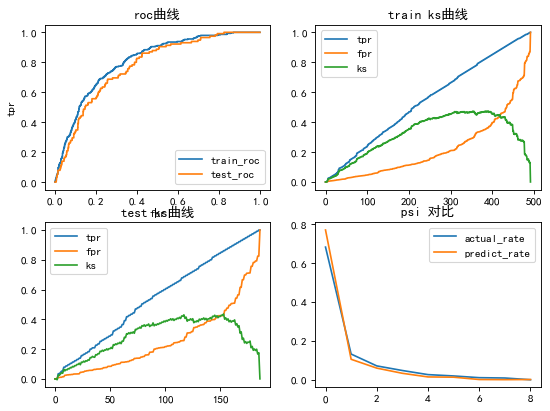

   actual  predict  actual_rate  predict_rate       psi
0    2387     1155     0.682029      0.770067  0.010688
1     463      158     0.132314      0.105400  0.006121
2     250       90     0.071457      0.060067  0.001978
3     167       50     0.047743      0.033400  0.005124
4      93       22     0.026600      0.014733  0.007011
5      69       20     0.019743      0.013400  0.002458
6      38        2     0.010886      0.001400  0.019455
7      32        1     0.009171      0.000733  0.021317
8       1        2     0.000314      0.001400  0.001622


(0.45480961773787487, 0.7887586120632006, 0.0757738897358962)

In [439]:

cal_ks_psi_auc(new_data, sel_fea, 'label', data_test, draw=True)

In [104]:
(0.5135878912968697, 0.8213243894048847, 0.22445088580423211)
(0.5006535947712418, 0.8125862859763789, 0.2171790211354662)
(0.5021327829377366, 0.8122010090585942, 0.20516903487974628)
(0.5063868822382754, 0.8107917669991974, 0.19293952127815575)

(0.5135878912968697, 0.8213243894048847, 0.22445088580423211)

2022-08-01下午log
['fea_286', 'stage_3_ret_rate', 'month1_ret', 'fea_72', 'fea_138', 'fea_12', 'fea_199', 'max_tax_pay', 'fea_94', 'fea_39', 'stage_0_ret_rate', 'fea_177', 'sum_inv', 'stage_7_ret_rate', 'stage_6_ret_rate', 'fea_319', 'stage_2_pay_rate', 'fea_253', 'fea_188', 'fea_137', 'sum_tax_pay', 'fea_276', 'month13_ret'] 23个(0.5195098504096749, 0.8079887310475682, 0.2295955044038141)
['month1_ret', 'max_tax_pay', 'fea_39', 'stage_0_ret_rate', 'stage_7_ret_rate', 'stage_6_ret_rate', 'fea_319', 'stage_2_pay_rate', 'sum_tax_pay', 'fea_137', 'fea_276', 'month13_ret'] 13个？(0.4638863063749582, 0.7888059239106247, 0.20146243704637998)
['sum_inv', 'fea_199', 'fea_286', 'stage_3_ret_rate', 'fea_72', 'fea_12', 'fea_138', 'max_tax_pay', 'fea_39', 'stage_0_ret_rate', 'fea_177', 'stage_6_ret_rate', 'fea_319', 'stage_2_pay_rate', 'fea_253', 'fea_188', 'fea_137', 'sum_tax_pay', 'fea_276', 'month13_ret']
 (0.5014112664366519, 0.8035762124274788, 0.23763951077992085) 20个


['month1_ret', 'max_tax_pay', 'fea_39', 'stage_0_ret_rate', 'stage_7_ret_rate', 'stage_6_ret_rate', 'fea_319', 'stage_2_pay_rate', 'sum_tax_pay', 'fea_137', 'fea_276', 'month13_ret', 'fea_72', 'fea_253', 'fea_188', 'fea_12', 'stage_3_ret_rate', 'sum_inv', 'fea_94'] 19个(0.505113161890884, 0.8028685725140194, 0.23647111998067277)



['item9_sum', 'month1_ret', 'month18_ret', 'stage_5_ret_rate', 'fea_60', 'fea_181', 'fea_72', 'fea_144', 'fea_159', 'fea_17', 'fea_179', 'fea_80', 'fea_56', 'fea_100', 'fea_71', 'stage_6_ret_rate', 'fea_190', 'month12_pay', 'item3_sum', 'fea_45', 'fea_253', 'fea_231', 'fea_184', 'sum_tax_pay', 'month21_ret', 'fea_137', 'month15_pay', 'fea_105', 'fea_155', 'pay_non0_month', 'month16_ret'] (0.4660360294238388, 0.7910965610308474, 0.07775736058543012)
['item9_sum', 'month1_ret', 'month18_ret', 'stage_5_ret_rate', 'fea_181', 'fea_144', 'fea_159', 'fea_17', 'fea_179', 'fea_80', 'fea_56', 'fea_100', 'fea_71', 'stage_6_ret_rate', 'fea_190', 'month12_pay', 'item3_sum', 'fea_45', 'fea_253', 'fea_231', 'fea_184', 'sum_tax_pay', 'fea_137', 'month15_pay', 'fea_105', 'fea_155', 'pay_non0_month', 'month16_ret'] (0.4665096403998624, 0.7870835613118842, 0.07720681317548989)
['item9_sum', 'month1_ret', 'month18_ret', 'stage_5_ret_rate', 'fea_181', 'fea_144', 'fea_17', 'fea_179', 'fea_80', 'fea_56', 'fea_100', 'fea_71', 'stage_6_ret_rate', 'fea_190', 'month12_pay', 'item3_sum', 'fea_45', 'fea_253', 'fea_231', 'fea_184', 'sum_tax_pay', 'fea_137', 'month15_pay', 'month16_ret'] (0.4642438183335054, 0.7847639851536719, 0.07178157063590852)
['item9_sum', 'month1_ret', 'stage_5_ret_rate', 'fea_144', 'fea_17', 'fea_179', 'fea_80', 'fea_56', 'fea_100', 'fea_71', 'stage_6_ret_rate', 'fea_190', 'item3_sum', 'fea_45', 'fea_253', 'fea_231', 'fea_184', 'sum_tax_pay', 'fea_137', 'month15_pay', 'month16_ret']  (0.4607367038991723, 0.7848499540539019, 0.07889308326348295)
['item9_sum', 'month1_ret', 'stage_5_ret_rate', 'fea_144', 'fea_17', 'fea_179', 'fea_80', 'fea_56', 'fea_71', 'stage_6_ret_rate', 'fea_190', 'item3_sum', 'fea_45', 'fea_253', 'fea_231', 'fea_184', 'sum_tax_pay', 'fea_137', 'month15_pay', 'month16_ret']  (0.46000302818383854, 0.7845242576175362, 0.082043116178343) 20个！！！！！##############



['item9_sum', 'month1_ret', 'stage_5_ret_rate', 'fea_72', 'fea_38', 'fea_17', 'fea_221', 'fea_5', 'max_tax_pay', 'fea_56', 'stage_0_ret_rate', 'fea_100', 'fea_69', 'stage_6_ret_rate', 'fea_190', 'month12_pay', 'fea_23', 'fea_231', 'fea_41', 'fea_184', 'fea_50', 'fea_19', 'fea_61', 'fea_276', 'fea_198', 'fea_105', 'fea_75', 'fea_122', 'fea_146', 'pay_non0_month']  (0.46026473997946443, 0.7911319708687233, 0.1283868877521325)
['item9_sum', 'month1_ret', 'stage_5_ret_rate', 'fea_72', 'fea_38', 'fea_17', 'fea_221', 'fea_5', 'max_tax_pay', 'fea_56', 'stage_0_ret_rate', 'fea_100', 'fea_69', 'stage_6_ret_rate', 'fea_190', 'month12_pay', 'fea_23', 'fea_231', 'fea_184', 'fea_50', 'fea_19', 'fea_61', 'fea_276', 'fea_105', 'fea_75', 'fea_122', 'fea_146', 'pay_non0_month'] (0.46103691248907264, 0.791085342245103, 0.12885635657592437)
['item9_sum', 'month1_ret', 'stage_5_ret_rate', 'fea_72', 'fea_38', 'fea_17', 'fea_221', 'fea_5', 'max_tax_pay', 'fea_56', 'stage_0_ret_rate', 'fea_100', 'stage_6_ret_rate', 'fea_190', 'month12_pay', 'fea_23', 'fea_231', 'fea_184', 'fea_50', 'fea_19', 'fea_61', 'fea_276', 'fea_105', 'fea_75', 'fea_122', 'fea_146', 'pay_non0_month'] (0.4611917112506825, 0.791074795272518, 0.12875081407558106)

['month1_ret', 'stage_5_ret_rate', 'fea_72', 'fea_38', 'fea_17', 'fea_221', 'fea_5', 'max_tax_pay', 'fea_56', 'stage_0_ret_rate', 'stage_6_ret_rate', 'fea_190', 'month12_pay', 'fea_23', 'fea_231', 'fea_184', 'fea_50', 'fea_19', 'fea_276', 'fea_105', 'fea_75', 'fea_122', 'fea_146'] (0.46120327036583986, 0.7904591821805607, 0.12838928843436145)

['month1_ret', 'stage_5_ret_rate', 'fea_72', 'fea_38', 'fea_17', 'fea_221', 'fea_5', 'max_tax_pay', 'fea_56', 'stage_0_ret_rate', 'stage_6_ret_rate', 'fea_190', 'month12_pay', 'fea_23', 'fea_231', 'fea_184', 'fea_50', 'fea_19', 'fea_276', 'fea_105', 'fea_122'] (0.4587996855973241, 0.7902479003699503, 0.1285127722219696)

['stage_5_ret_rate', 'fea_72', 'fea_38', 'fea_17', 'fea_221', 'fea_5', 'max_tax_pay', 'fea_56', 'stage_0_ret_rate', 'stage_6_ret_rate', 'fea_190', 'month12_pay', 'fea_23', 'fea_231', 'fea_184', 'fea_50', 'fea_276', 'fea_105', 'fea_122'] (0.45155415578734914, 0.7904622094555769, 0.12579316725798)

['stage_5_ret_rate', 'fea_72', 'fea_38', 'fea_17', 'fea_221', 'fea_5', 'max_tax_pay', 'fea_56', 'stage_0_ret_rate', 'stage_6_ret_rate', 'fea_190', 'month12_pay', 'fea_23', 'fea_231', 'fea_184', 'fea_50', 'fea_276', 'fea_105', 'fea_122', 'pay_non0_month']  (0.4529700001710367, 0.7907515058598615, 0.12814063882439797)



['fea_198', 'fea_56', 'fea_38', 'fea_23', 'fea_5', 'fea_61', 'fea_148', 'fea_276', 'fea_50', 'fea_122', 'fea_221', 'fea_80', 'fea_75', 'fea_146', 'fea_187'] (0.4164956376885714, 0.7636145318816485, 0.1715044637000866)
前选 选出来了15个特征
R2=0.17012800105735776,continue! fea_50
R2=0.1637024834815443,continue! fea_75
R2=0.14857246715295208,continue! fea_5
for selection over!
['fea_221', 'fea_23', 'fea_198', 'fea_187', 'fea_122', 'fea_80', 'fea_56', 'fea_146', 'fea_276', 'fea_148', 'fea_61', 'fea_38']
后选出来了12个特征 (0.3990811835980031, 0.7561583884681014, 0.14857246715295208)


['month13_ret', 'month14_pay', 'stage_6_ret_rate', 'stage_0_ret_rate', 'month21_ret', 'stage_1_pay_rate', 'stage_2_ret_rate', 'month29_ret', 'stage_4_ret_rate', 'stage_7_ret_rate', 'item6_sum', 'month22_ret', 'month16_ret']
前选 选出来了13个特征
R2=0.21145229698894333,continue! month13_ret
R2=0.19375672431599003,continue! stage_7_ret_rate
R2=0.18307060539515738,continue! item6_sum
for selection over!
['stage_6_ret_rate', 'stage_1_pay_rate', 'stage_2_ret_rate', 'month29_ret', 'month22_ret', 'stage_0_ret_rate', 'month21_ret', 'stage_4_ret_rate', 'month16_ret', 'month14_pay']
后选出来了10个特征


['month17_ret', 'stage_3_pay_rate', 'stage_0_ret_rate', 'stage_6_ret_rate', 'item1_sum', 'month16_pay', 'stage_5_ret_rate', 'month22_ret', 'month20_ret']
前选 选出来了9个特征
R2=0.14068414676513336,continue! month22_ret
R2=0.13064974102925228,continue! month17_ret
for selection over!
['stage_3_pay_rate', 'month16_pay', 'stage_6_ret_rate', 'month20_ret', 'stage_5_ret_rate', 'item1_sum', 'stage_0_ret_rate']
后选出来了7个特征 (0.43516882549221636, 0.7731132229321224, 0.13064974102925228)


['pay_non0_month', 'fea_56', 'stage_0_ret_rate', 'stage_6_ret_rate', 'max_tax_pay', 'fea_137', 'stage_5_ret_rate', 'fea_160', 'fea_72', 'fea_231', 'month1_ret', 'item9_sum', 'fea_179', 'fea_69', 'inv_mean', 'fea_190', 'fea_184', 'month12_pay', 'fea_80', 'fea_19', 'item3_sum', 'fea_100', 'fea_105', 'fea_41', 'fea_17'] (0.47184461463531024, 0.7843152052541138, 0.22063084524128368)
前选 选出来了25个特征 
R2=0.17557556999006568,continue! max_tax_pay (0.4735213214955609, 0.7811636146142666, 0.17557556999006568)
R2=0.1745947451982613,continue! fea_19
R2=0.15237121739842574,continue! stage_0_ret_rate
R2=0.1430832422873635,continue! fea_69
R2=0.13447088073370514,continue! fea_160
R2=0.13026535210332812,continue! fea_41
for selection over!
['item9_sum', 'month1_ret', 'stage_5_ret_rate', 'fea_72', 'fea_17', 'fea_179', 'fea_80', 'fea_56', 'fea_100', 'inv_mean', 'stage_6_ret_rate', 'fea_190', 'month12_pay', 'item3_sum', 'fea_231', 'fea_184', 'fea_137', 'fea_105', 'pay_non0_month']
后选出来了19个特征  (0.4516713666998634, 0.7722624694958763, 0.13026535210332812)


['month1_pay', 'fea_56', 'month14_pay', 'stage_0_ret_rate', 'max_tax_pay', 'stage_3_ret_rate', 'month16_pay', 'inv_mean', 'fea_94', 'month7_pay', 'fea_160', 'fea_181', 'sum_tax_pay', 'fea_177', 'fea_72', 'stage_4_pay_rate', 'month0_pay']
前选 选出来了17个特征
R2=0.2969517477949592,continue! stage_3_ret_rate
R2=0.2886729905927072,continue! fea_94
R2=0.27417128060269996,continue! fea_160
for selection over!
['month16_pay', 'month7_pay', 'month1_pay', 'stage_4_pay_rate', 'max_tax_pay', 'month0_pay', 'fea_56', 'stage_0_ret_rate', 'sum_tax_pay', 'fea_181', 'fea_177', 'fea_72', 'inv_mean', 'month14_pay']
后选出来了14个特征 (0.4578076369646379, 0.785430872093703, 0.27417128060269996)


['month17_ret', 'stage_3_pay_rate', 'stage_3_ret_rate', 'max_tax_pay', 'fea_144', 'stage_2_pay_rate', 'stage_0_ret_rate', 'month2_pay', 'month1_ret', 'stage_1_pay_rate', 'fea_160', 'stage_4_ret_rate', 'month22_ret', 'fea_140', 'month25_ret', 'stage_5_ret_rate', 'month31_ret', 'month15_pay', 'fea_50', 'fea_311', 'fea_28', 'item9_sum', 'fea_155', 'month9_pay', 'month16_pay', 'fea_129', 'sum_inv', 'month1_pay']
前选 选出来了28个特征 (0.4801712644859016, 0.7892507640744417, 0.3694990265932195)
['month1_ret', 'month25_ret', 'fea_311', 'fea_144', 'month1_pay', 'month2_pay', 'stage_4_ret_rate', 'fea_155', 'fea_129']
后选出来了9个特征 (0.4044463876294745, 0.747210769575912, 0.19967836926708898)

['month16_pay', 'item9_sum', 'month1_ret', 'month2_pay', 'month25_ret', 'fea_311', 'fea_129', 'fea_155', 'stage_4_ret_rate', 'fea_144', 'month1_pay', 'month9_pay']
后选出来了12个特征(0.4067788758998584, 0.7541480535547846, 0.15970636946074127)
['sum_inv', 'month9_pay', 'fea_140', 'item9_sum', 'month16_pay', 'month1_ret', 'month25_ret', 'fea_311', 'fea_144', 'month1_pay', 'month2_pay', 'stage_4_ret_rate', 'fea_155', 'fea_129'] (0.41546012459557935, 0.7561621956831108, 0.17845194285033728)

2022-08-01前后选择的Log --- 由于psi计算错误，所以全无效

['fea_231', 'max_tax_pay', 'stage_3_pay_rate', 'stage_3_ret_rate', 'fea_144', 'stage_0_ret_rate', 'month13_ret', 'fea_177', 'month1_pay', 'pay_non0_month', 'fea_60', 'month13_pay', 'fea_140', 'fea_199', 'inv_mean', 'item9_sum', 'fea_17']
前选 选出来了17个特征
R2=0.26451594873570683,continue! stage_3_ret_rate
R2=0.22142738164394085,continue! inv_mean
R2=0.212474088484084,continue! fea_199
R2=0.17985598979983014,continue! stage_3_pay_rate
R2=0.161425567029292,continue! fea_231
R2=0.14540869633636178,continue! stage_0_ret_rate
R2=0.12278547248058752,continue! month13_ret
R2=0.12129875253642398,continue! month13_pay
R2=0.12051372226144144,continue! item9_sum
R2=0.11415502905185937,continue! fea_60
for selection over!
['max_tax_pay', 'fea_140', 'fea_177', 'pay_non0_month', 'fea_144', 'month1_pay', 'fea_17']
后选出来了7个特征

['month18_ret', 'stage_6_ret_rate', 'month15_pay', 'stage_0_ret_rate', 'fea_137', 'fea_56', 'stage_1_pay_rate', 'fea_23', 'fea_253', 'fea_264', 'sum_tax_pay', 'fea_160', 'month21_ret', 'month23_ret', 'fea_181', 'fea_100', 'fea_6', 'item3_sum', 'ratal_rate']
前选 选出来了19个特征
R2=0.252364582589445,continue! fea_56
R2=0.2510391646448202,continue! month23_ret
for selection over!
['month18_ret', 'fea_160', 'ratal_rate', 'stage_1_pay_rate', 'fea_6', 'fea_181', 'stage_0_ret_rate', 'fea_100', 'stage_6_ret_rate', 'fea_23', 'item3_sum', 'fea_253', 'fea_137', 'sum_tax_pay', 'month21_ret', 'month15_pay', 'fea_264']
后选出来了17个特征

['month17_ret', 'fea_60', 'stage_0_ret_rate', 'stage_6_ret_rate', 'fea_71', 'fea_12', 'month13_pay', 'fea_5', 'month12_pay', 'fea_72', 'fea_50', 'month16_ret', 'fea_253', 'fea_160', 'fea_155', 'stage_3_pay_rate', 'fea_159', 'fea_1', 'fea_144', 'fea_45', 'fea_319']
前选 选出来了21个特征
R2=0.20884971193567337,continue! fea_160
R2=0.2070467540998261,continue! fea_50
R2=0.17779886542935364,continue! stage_3_pay_rate
R2=0.17055564470242746,continue! stage_0_ret_rate
R2=0.15926437236989294,continue! fea_12
R2=0.13873828591632076,continue! stage_6_ret_rate
R2=0.1234144343963709,continue! fea_72
R2=0.11752538173608362,continue! fea_144
R2=0.10940438167701423,continue! fea_5
R2=0.09959698953770252,continue! fea_159
R2=0.0875606443427961,continue! month17_ret
R2=0.08660816863432477,continue! month12_pay
R2=0.08188828696191966,continue! fea_155
R2=0.07707172236078805,continue! month13_pay
R2=0.0752699921228404,continue! fea_319
for selection over!
['fea_60', 'fea_71', 'fea_1', 'fea_45', 'fea_253', 'month16_ret']
后选出来了6个特征

将上面2次合并，重新后选
R2=0.10890901980904649,continue! month12_pay
for selection over!
['month18_ret', 'fea_60', 'fea_6', 'fea_181', 'fea_144', 'fea_159', 'fea_100', 'fea_71', 'fea_1', 'stage_3_pay_rate', 'fea_319', 'fea_45', 'fea_253', 'sum_tax_pay', 'month21_ret', 'month15_pay', 'month17_ret', 'fea_155', 'month16_ret']
后选出来了19个特征  (0.411216297873889, 0.7673174551372168, 0.10890901980904649)